<a href="https://colab.research.google.com/github/pietroduke/plant-identification-forest/blob/main/icce_domain_adaptation_vit_center.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import os
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
import seaborn as sns
from typing import Dict, List, Optional, Callable
import json

In [4]:
vit_models = timm.list_models('*vit*base*')
print(vit_models)

['convit_base', 'crossvit_base_240', 'davit_base', 'davit_base_fl', 'flexivit_base', 'gcvit_base', 'maxvit_base_tf_224', 'maxvit_base_tf_384', 'maxvit_base_tf_512', 'maxvit_rmlp_base_rw_224', 'maxvit_rmlp_base_rw_384', 'maxxvitv2_rmlp_base_rw_224', 'maxxvitv2_rmlp_base_rw_384', 'mvitv2_base', 'mvitv2_base_cls', 'naflexvit_base_patch16_gap', 'naflexvit_base_patch16_map', 'naflexvit_base_patch16_par_gap', 'naflexvit_base_patch16_parfac_gap', 'naflexvit_base_patch16_siglip', 'nextvit_base', 'samvit_base_patch16', 'samvit_base_patch16_224', 'vit_base_mci_224', 'vit_base_patch8_224', 'vit_base_patch14_dinov2', 'vit_base_patch14_reg4_dinov2', 'vit_base_patch16_18x2_224', 'vit_base_patch16_224', 'vit_base_patch16_224_miil', 'vit_base_patch16_384', 'vit_base_patch16_clip_224', 'vit_base_patch16_clip_384', 'vit_base_patch16_clip_quickgelu_224', 'vit_base_patch16_dinov3', 'vit_base_patch16_dinov3_qkvb', 'vit_base_patch16_gap_224', 'vit_base_patch16_plus_240', 'vit_base_patch16_plus_clip_240', 'v

In [ ]:
# import timm
# print(timm.__version__)

In [5]:
!unzip  /content/drive/MyDrive/PlantIdentification/Single.zip

Streaming output truncated to the last 5000 lines.
  inflating: Single/train/Đa/crop_327_patch17.png  
Single/train/Đa/crop_327_patch18.png:  mismatching "local" filename (Single/train/─Рa/crop_327_patch18.png),
         continuing with "central" filename version
  inflating: Single/train/Đa/crop_327_patch18.png  
Single/train/Đa/crop_327_patch19.png:  mismatching "local" filename (Single/train/─Рa/crop_327_patch19.png),
         continuing with "central" filename version
  inflating: Single/train/Đa/crop_327_patch19.png  
Single/train/Đa/crop_327_patch2.png:  mismatching "local" filename (Single/train/─Рa/crop_327_patch2.png),
         continuing with "central" filename version
  inflating: Single/train/Đa/crop_327_patch2.png  
Single/train/Đa/crop_327_patch20.png:  mismatching "local" filename (Single/train/─Рa/crop_327_patch20.png),
         continuing with "central" filename version
  inflating: Single/train/Đa/crop_327_patch20.png  
Single/train/Đa/crop_327_patch21.png:  mismatchi

In [6]:
!rm -rf "/content/Single/test/Bời Lời"
!rm -rf "/content/Single/test/Lim xanh"
!rm -rf "/content/Single/test/Sếu"
!rm -rf "/content/Single/test/Lòng Mang"
!rm -rf "/content/Single/test/Chẹo"
!rm -rf "/content/Single/test/Mé Cò Ke"
!rm -rf "/content/Single/test/Dẻ cau"
!rm -rf "/content/Single/test/Nanh Chuột"
!rm -rf "/content/Single/test/Thôi Ba"
!rm -rf "/content/Single/test/Bời Lời Lá Tròn"
!rm -rf "/content/Single/test/Sồi Xanh"
!rm -rf "/content/Single/test/Lim Xẹt"

!rm -rf "/content/Single/train/Bời Lời"
!rm -rf "/content/Single/train/Lim xanh"
!rm -rf "/content/Single/train/Sếu"
!rm -rf "/content/Single/train/Lòng Mang"
!rm -rf "/content/Single/train/Chẹo"
!rm -rf "/content/Single/train/Mé Cò Ke"
!rm -rf "/content/Single/train/Dẻ cau"
!rm -rf "/content/Single/train/Nanh Chuột"
!rm -rf "/content/Single/train/Thôi Ba"
!rm -rf "/content/Single/train/Bời Lời Lá Tròn"
!rm -rf "/content/Single/train/Sồi Xanh"
!rm -rf "/content/Single/train/Lim Xẹt"

!rm -rf "/content/Single/val/Bời Lời"
!rm -rf "/content/Single/val/Lim xanh"
!rm -rf "/content/Single/val/Sếu"
!rm -rf "/content/Single/val/Lòng Mang"
!rm -rf "/content/Single/val/Chẹo"
!rm -rf "/content/Single/val/Mé Cò Ke"
!rm -rf "/content/Single/val/Dẻ cau"
!rm -rf "/content/Single/val/Nanh Chuột"
!rm -rf "/content/Single/val/Thôi Ba"
!rm -rf "/content/Single/val/Bời Lời Lá Tròn"
!rm -rf "/content/Single/val/Sồi Xanh"
!rm -rf "/content/Single/val/Lim Xẹt"

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    """Focal Loss for handling class imbalance"""
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# --- Primary Losses ---

class OnlineTripletLoss(nn.Module):
    """Triplet Loss with Batch Hard mining"""
    def __init__(self, margin=0.3):
        super(OnlineTripletLoss, self).__init__()
        self.margin = margin

    def forward(self, features, targets):
        # Pairwise distances
        n = features.size(0)
        dist = torch.pow(features, 2).sum(dim=1, keepdim=True).expand(n, n)
        dist = dist + dist.t()
        dist.addmm_(features, features.t(), beta=1, alpha=-2)
        dist = dist.clamp(min=1e-12).sqrt()  # for numerical stability

        # Masks
        mask_anchor_positive = targets.expand(n, n).eq(targets.expand(n, n).t())
        mask_anchor_negative = targets.expand(n, n).ne(targets.expand(n, n).t())

        # Batch Hard Mining
        # Max distance for positives (hardest positive)
        hardest_positive_dist = (dist * mask_anchor_positive.float()).max(dim=1)[0]

        # Min distance for negatives (hardest negative)
        # Add max_dist to invalid positions before taking min
        max_dist = dist.max().item()
        hardest_negative_dist = (dist + max_dist * (~mask_anchor_negative).float()).min(dim=1)[0]

        triplet_loss = F.relu(hardest_positive_dist - hardest_negative_dist + self.margin)
        return triplet_loss.mean()

class CenterLoss(nn.Module):
    """Center Loss for reducing intra-class variance"""
    def __init__(self, num_classes, feat_dim, use_gpu=True):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.use_gpu = use_gpu

        if self.use_gpu:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())
        else:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))

    def forward(self, features, targets):
        batch_size = features.size(0)
        distmat = torch.pow(features, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(features, self.centers.t(), beta=1, alpha=-2)

        classes = torch.arange(self.num_classes).long()
        if self.use_gpu: classes = classes.cuda()

        labels = targets.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = distmat * mask.float()
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size
        return loss

# --- Secondary Losses ---

class EntropyLoss(nn.Module):
    """Minimum Entropy Regularization"""
    def __init__(self):
        super(EntropyLoss, self).__init__()

    def forward(self, logits):
        p = F.softmax(logits, dim=1)
        log_p = F.log_softmax(logits, dim=1)
        loss = -torch.sum(p * log_p, dim=1).mean()
        return loss

class PNormLoss(nn.Module):
    """P-Norm Regularization on Features"""
    def __init__(self, p=2):
        super(PNormLoss, self).__init__()
        self.p = p

    def forward(self, features):
        return torch.norm(features, p=self.p, dim=1).mean()

class CORALLoss(nn.Module):
    """Correlation Alignment Loss (Placeholder for single domain)"""
    def __init__(self):
        super(CORALLoss, self).__init__()

    def forward(self, features):
        # For single batch/domain, usually used to decorrelate or match a prior.
        # Here we just return 0 if no target domain provided, or covariance norm.
        # Simplified: minimize covariance norm (decorrelation)
        n = features.size(0)
        d = features.size(1)
        mean = features.mean(dim=0, keepdim=True)
        features_centered = features - mean
        cov = features_centered.t().mm(features_centered) / (n - 1)
        return torch.norm(cov, p='fro')

class CombinedLoss(nn.Module):
    """Combined Loss: L_total = L_class + lambda1 * L_primary + lambda2 * L_secondary"""
    def __init__(self, base_criterion, primary_criteria=None, secondary_criteria=None,
                 lambda_primary=0.01, lambda_secondary=0.01):
        super(CombinedLoss, self).__init__()
        self.base_criterion = base_criterion
        self.primary_criteria = primary_criteria if primary_criteria else []
        self.secondary_criteria = secondary_criteria if secondary_criteria else []
        self.lambda_primary = lambda_primary
        self.lambda_secondary = lambda_secondary

    def forward(self, logits, labels, features):
        # Base Classification Loss
        loss = self.base_criterion(logits, labels)

        # Primary Losses (require features and labels)
        if self.primary_criteria:
            p_loss = 0
            for criterion in self.primary_criteria:
                p_loss += criterion(features, labels)
            loss += self.lambda_primary * p_loss

        # Secondary Losses (varied inputs)
        if self.secondary_criteria:
            s_loss = 0
            for criterion in self.secondary_criteria:
                if isinstance(criterion, EntropyLoss):
                    s_loss += criterion(logits)
                elif isinstance(criterion, (PNormLoss, CORALLoss)):
                    s_loss += criterion(features)
                # Add other cases if needed
            loss += self.lambda_secondary * s_loss

        return loss

In [8]:
# class EarlyStopping:
#     """Early stopping callback"""
#     def __init__(self, patience=7, min_delta=0, mode='max'):
#         self.patience = patience
#         self.min_delta = min_delta
#         self.mode = mode
#         self.counter = 0
#         self.best_score = None
#         self.early_stop = False

#     def __call__(self, score):
#         if self.best_score is None:
#             self.best_score = score
#         elif self.mode == 'max':
#             if score < self.best_score + self.min_delta:
#                 self.counter += 1
#                 if self.counter >= self.patience:
#                     self.early_stop = True
#             else:
#                 self.best_score = score
#                 self.counter = 0
#         else:  # mode == 'min'
#             if score > self.best_score - self.min_delta:
#                 self.counter += 1
#                 if self.counter >= self.patience:
#                     self.early_stop = True
#             else:
#                 self.best_score = score
#                 self.counter = 0

#         return self.early_stop

# class ModelCheckpoint:
#     """Model checkpoint callback"""
#     def __init__(self, filepath, monitor='val_loss', mode='min', save_best_only=True):
#         self.filepath = filepath
#         self.monitor = monitor
#         self.mode = mode
#         self.save_best_only = save_best_only
#         self.best_score = None

#     def __call__(self, model, optimizer, epoch, metrics):
#         score = metrics.get(self.monitor)

#         if not self.save_best_only:
#             self._save_model(model, optimizer, epoch, metrics)
#             return False

#         if self.best_score is None:
#             self.best_score = score
#             self._save_model(model, optimizer, epoch, metrics)
#             return True

#         improved = False
#         if self.mode == 'max' and score > self.best_score:
#             self.best_score = score
#             self._save_model(model, optimizer, epoch, metrics)
#             improved = True
#         elif self.mode == 'min' and score < self.best_score:
#             self.best_score = score
#             self._save_model(model, optimizer, epoch, metrics)
#             improved = True

#         return improved

#     def _save_model(self, model, optimizer, epoch, metrics):
#         torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'metrics': metrics
#         }, self.filepath)

# class ReduceLROnPlateau:
#     """Reduce learning rate when a metric has stopped improving"""
#     def __init__(self, optimizer, monitor='val_loss', mode='min', factor=0.5,
#                  patience=5, min_lr=1e-6, verbose=1):
#         self.optimizer = optimizer
#         self.monitor = monitor
#         self.mode = mode
#         self.factor = factor
#         self.patience = patience
#         self.min_lr = min_lr
#         self.verbose = verbose

#         self.best_score = None
#         self.counter = 0
#         self.current_lr = optimizer.param_groups[0]['lr']

#     def __call__(self, metrics):
#         score = metrics.get(self.monitor)

#         if self.best_score is None:
#             self.best_score = score
#             return

#         improved = False
#         if self.mode == 'min':
#             improved = score < self.best_score
#         else:  # mode == 'max'
#             improved = score > self.best_score

#         if improved:
#             self.best_score = score
#             self.counter = 0
#         else:
#             self.counter += 1

#             if self.counter >= self.patience:
#                 old_lr = self.current_lr
#                 new_lr = max(old_lr * self.factor, self.min_lr)

#                 if new_lr < old_lr:
#                     for param_group in self.optimizer.param_groups:
#                         param_group['lr'] = new_lr
#                     self.current_lr = new_lr
#                     self.counter = 0

#                     if self.verbose:
#                         print(f"\n📉 ReduceLROnPlateau: reducing learning rate from {old_lr:.6f} to {new_lr:.6f}")

# class LearningRateSchedulerCallback:
#     """Learning rate scheduler callback with warmup"""
#     def __init__(self, optimizer, warmup_epochs=5, min_lr=1e-6):
#         self.optimizer = optimizer
#         self.warmup_epochs = warmup_epochs
#         self.min_lr = min_lr
#         self.initial_lr = optimizer.param_groups[0]['lr']

#     def on_epoch_end(self, epoch, scheduler):
#         if epoch < self.warmup_epochs:
#             # Warmup phase
#             lr = self.initial_lr * (epoch + 1) / self.warmup_epochs
#             for param_group in self.optimizer.param_groups:
#                 param_group['lr'] = lr
#         else:
#             # Normal scheduling
#             scheduler.step()

In [32]:
class EarlyStopping:
    """Early stopping callback - dùng val_acc"""
    def __init__(self, patience=20, min_delta=0, mode='max'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif self.mode == 'max':
            if score < self.best_score + self.min_delta:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.counter = 0
        else:  # mode == 'min'
            if score > self.best_score - self.min_delta:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.counter = 0

        return self.early_stop


class ModelCheckpoint:
    """Model checkpoint callback - dùng val_acc"""
    def __init__(self, filepath, monitor='val_acc', mode='max', save_best_only=True):
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.save_best_only = save_best_only
        self.best_score = None

    def __call__(self, model, optimizer, epoch, metrics):
        score = metrics.get(self.monitor)

        if not self.save_best_only:
            self._save_model(model, optimizer, epoch, metrics)
            return False

        if self.best_score is None:
            self.best_score = score
            self._save_model(model, optimizer, epoch, metrics)
            return True

        improved = False
        if self.mode == 'max' and score > self.best_score:
            self.best_score = score
            self._save_model(model, optimizer, epoch, metrics)
            improved = True
        elif self.mode == 'min' and score < self.best_score:
            self.best_score = score
            self._save_model(model, optimizer, epoch, metrics)
            improved = True

        return improved

    def _save_model(self, model, optimizer, epoch, metrics):
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'metrics': metrics
        }, self.filepath)


class ReduceLROnPlateau:
    """Reduce learning rate when accuracy has stopped improving"""
    def __init__(self, optimizer, monitor='val_acc', mode='max', factor=0.5,
                 patience=5, min_lr=1e-6, verbose=1):
        self.optimizer = optimizer
        self.monitor = monitor
        self.mode = mode
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.verbose = verbose

        self.best_score = None
        self.counter = 0
        self.current_lr = optimizer.param_groups[0]['lr']

    def __call__(self, metrics):
        score = metrics.get(self.monitor)

        if self.best_score is None:
            self.best_score = score
            return

        improved = False
        if self.mode == 'min':
            improved = score < self.best_score
        else:  # mode == 'max'
            improved = score > self.best_score

        if improved:
            self.best_score = score
            self.counter = 0
        else:
            self.counter += 1

            if self.counter >= self.patience:
                old_lr = self.current_lr
                new_lr = max(old_lr * self.factor, self.min_lr)

                if new_lr < old_lr:
                    for param_group in self.optimizer.param_groups:
                        param_group['lr'] = new_lr
                    self.current_lr = new_lr
                    self.counter = 0

                    if self.verbose:
                        print(f"\n📉 ReduceLROnPlateau: reducing learning rate from {old_lr:.6f} to {new_lr:.6f}")


class LearningRateSchedulerCallback:
    """Learning rate scheduler callback with warmup"""
    def __init__(self, optimizer, warmup_epochs=5, min_lr=1e-6):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.min_lr = min_lr
        self.initial_lr = optimizer.param_groups[0]['lr']

    def on_epoch_end(self, epoch, scheduler):
        if epoch < self.warmup_epochs:
            # Warmup phase
            lr = self.initial_lr * (epoch + 1) / self.warmup_epochs
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr
        else:
            # Normal scheduling
            scheduler.step()


In [33]:
class PlantModel(nn.Module):
    """Wrapper to return both features and logits"""
    def __init__(self, model_name, num_classes, pretrained=True):
        super(PlantModel, self).__init__()
        # Create model with num_classes=0 to get pooling output (features)
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0)
        self.num_features = self.backbone.num_features
        self.classifier = nn.Linear(self.num_features, num_classes)

    def forward(self, x):
        features = self.backbone(x)
        logits = self.classifier(features)
        return logits, features

class ModelTrainer:
    def __init__(self, train_dir, val_dir, test_dir, model_name='vit_base_patch16_224',
                 img_size=224, batch_size=64, lr=1e-4, epochs=50,
                 use_focal_loss=False, focal_alpha=1, focal_gamma=2,
                 primary_loss=None, secondary_loss=None,
                 lambda_primary=0.01, lambda_secondary=0.01,
                 device=None):

        self.train_dir = train_dir
        self.val_dir = val_dir
        self.test_dir = test_dir
        self.model_name = model_name
        self.img_size = img_size
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs
        self.use_focal_loss = use_focal_loss

        # New Loss Params
        self.primary_loss_name = primary_loss
        self.secondary_loss_name = secondary_loss
        self.lambda_primary = lambda_primary
        self.lambda_secondary = lambda_secondary

        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []
        self.val_precisions = []
        self.val_recalls = []
        self.val_f1s = []
        self.learning_rates = []

        # Callbacks
        self.callbacks = []

        self._setup_data()
        self._setup_model(focal_alpha, focal_gamma)
        self._setup_optimizer()

    def _setup_data(self):
        """Setup DataLoader"""
        train_transform = transforms.Compose([
            transforms.Resize((self.img_size, self.img_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
            transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.3),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        test_transform = transforms.Compose([
            transforms.Resize((self.img_size, self.img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.train_dataset = datasets.ImageFolder(self.train_dir, transform=train_transform)
        self.val_dataset = datasets.ImageFolder(self.val_dir, transform=test_transform)
        self.test_dataset = datasets.ImageFolder(self.test_dir, transform=test_transform)

        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4, pin_memory=True)
        self.val_loader = DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4, pin_memory=True)
        self.test_loader = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4, pin_memory=True)

        self.num_classes = len(self.train_dataset.classes)
        self.class_names = self.train_dataset.classes
        print(f"Number of classes: {self.num_classes}")

    def _setup_model(self, focal_alpha, focal_gamma):
        """Setup model and combined loss function"""
        # Use Wrapper to get features
        self.model = PlantModel(self.model_name, self.num_classes)
        self.model = self.model.to(self.device)

        # Base Loss
        if self.use_focal_loss:
            base_loss = FocalLoss(alpha=focal_alpha, gamma=focal_gamma)
            print(f"Using Focal Loss (alpha={focal_alpha}, gamma={focal_gamma})")
        else:
            base_loss = nn.CrossEntropyLoss()
            print("Using CrossEntropy Loss")

        # Primary Losses
        primary_criteria = []
        if self.primary_loss_name:
            if 'triplet' in self.primary_loss_name.lower():
                print("Adding Triplet Loss")
                primary_criteria.append(OnlineTripletLoss())
            if 'center' in self.primary_loss_name.lower():
                print("Adding Center Loss")
                # CenterLoss requires feature dimension
                feat_dim = self.model.num_features
                primary_criteria.append(CenterLoss(self.num_classes, feat_dim, use_gpu=(self.device.type=='cuda')))

        # Secondary Losses
        secondary_criteria = []
        if self.secondary_loss_name:
            names = self.secondary_loss_name.lower()
            if 'entropy' in names:
                print("Adding Entropy Loss")
                secondary_criteria.append(EntropyLoss())
            if 'pnorm' in names:
                print("Adding P-Norm Loss")
                secondary_criteria.append(PNormLoss())
            if 'coral' in names:
                print("Adding CORAL Loss")
                secondary_criteria.append(CORALLoss())

        # Combined Loss
        self.criterion = CombinedLoss(
            base_loss,
            primary_criteria,
            secondary_criteria,
            self.lambda_primary,
            self.lambda_secondary
        )

        print(f"Model: {self.model_name}")
        print(f"Device: {self.device}")

    def _setup_optimizer(self):
        """Setup optimizer and scheduler"""
        # Collect parameters: model params + loss params (e.g., centers)
        params = list(self.model.parameters())

        # Check if any primary criteria is CenterLoss and add its parameters
        for criterion in self.criterion.primary_criteria:
            if isinstance(criterion, CenterLoss):
                print("Adding CenterLoss centers to optimizer")
                params.append(criterion.centers)

        self.optimizer = optim.AdamW(params, lr=self.lr, weight_decay=0.05)
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=self.epochs)

    def add_callback(self, callback):
        self.callbacks.append(callback)

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(self.train_loader, desc="Training")
        for images, labels in pbar:
            images, labels = images.to(self.device), labels.to(self.device)

            self.optimizer.zero_grad()
            # Model returns (logits, features)
            logits, features = self.model(images)

            # Criterion expects (logits, labels, features)
            loss = self.criterion(logits, labels, features)

            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            pbar.set_postfix({'Loss': f'{loss.item():.4f}', 'Acc': f'{100.*correct/total:.2f}%'})

        return running_loss / len(self.train_loader), 100. * correct / total

    def validate_epoch(self, data_loader, desc="Validation"):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_predicted = []
        all_labels = []

        with torch.no_grad():
            pbar = tqdm(data_loader, desc=desc)
            for images, labels in pbar:
                images, labels = images.to(self.device), labels.to(self.device)

                logits, features = self.model(images)
                loss = self.criterion(logits, labels, features)

                running_loss += loss.item()
                _, predicted = torch.max(logits, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_predicted.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                pbar.set_postfix({'Loss': f'{loss.item():.4f}', 'Acc': f'{100.*correct/total:.2f}%'})

        epoch_loss = running_loss / len(data_loader)
        epoch_acc = 100. * correct / total
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predicted, average='macro', zero_division=0)

        return epoch_loss, epoch_acc, precision*100, recall*100, f1*100, all_predicted, all_labels

    def train(self):
        print("Start training..."); print("="*50)
        for epoch in range(self.epochs):
            start_time = time.time()
            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc, val_precision, val_recall, val_f1, _, _ = self.validate_epoch(self.val_loader, "Validation")
            current_lr = self.optimizer.param_groups[0]['lr']

            self.train_losses.append(train_loss); self.val_losses.append(val_loss)
            self.train_accs.append(train_acc); self.val_accs.append(val_acc)
            self.val_precisions.append(val_precision); self.val_recalls.append(val_recall)
            self.val_f1s.append(val_f1); self.learning_rates.append(current_lr)

            metrics = {'train_loss': train_loss, 'train_acc': train_acc, 'val_loss': val_loss, 'val_acc': val_acc,
                       'val_precision': val_precision, 'val_recall': val_recall, 'val_f1': val_f1}

            should_stop = False
            for callback in self.callbacks:
                if isinstance(callback, EarlyStopping):
                    if callback(val_loss):
                        print(f"🛑 Early stopping triggered at epoch {epoch+1}"); should_stop = True; break
                elif isinstance(callback, ModelCheckpoint):
                    if callback(self.model, self.optimizer, epoch, metrics):
                        print(f"💾 Saved best model at epoch {epoch+1}")
                elif isinstance(callback, ReduceLROnPlateau):
                    callback(metrics)
                elif isinstance(callback, LearningRateSchedulerCallback):
                    callback.on_epoch_end(epoch, self.scheduler)

            if not any(isinstance(cb, LearningRateSchedulerCallback) for cb in self.callbacks):
                self.scheduler.step()

            print(f"Epoch {epoch+1}/{self.epochs}")
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
            print(f"Val Precision: {val_precision:.2f}%, Val Recall: {val_recall:.2f}%, Val F1: {val_f1:.2f}%")
            print(f"LR: {current_lr:.6f}, Time: {time.time()-start_time:.2f}s")
            print("-" * 70)
            if should_stop: break

        return self._get_best_checkpoint_path()

    def _get_best_checkpoint_path(self):
        for callback in self.callbacks:
            if isinstance(callback, ModelCheckpoint): return callback.filepath
        return None

    def evaluate_on_test(self, model_path=None):
        if model_path and os.path.exists(model_path):
            print(f"Loading model from {model_path}")
            checkpoint = torch.load(model_path)
            self.model.load_state_dict(checkpoint['model_state_dict'])
        print("\n" + "="*70 + "\n🧪 EVALUATING ON TEST SET\n" + "="*70)
        test_loss, test_acc, test_precision, test_recall, test_f1, test_predicted, test_labels = self.validate_epoch(self.test_loader, "Testing")
        precision_per_class, recall_per_class, f1_per_class, support = precision_recall_fscore_support(test_labels, test_predicted, average=None, zero_division=0)
        print("\n🎯 DETAILED TEST RESULTS\n" + "="*70)
        print(f"Overall Accuracy: {test_acc:.2f}%"); print(f"Overall Precision (Macro): {test_precision:.2f}%")
        print(f"Overall Recall (Macro): {test_recall:.2f}%"); print(f"Overall F1-Score (Macro): {test_f1:.2f}%")
        print("="*70)
        print("\n📊 PER-CLASS METRICS:"); print("-"*70)
        print(f"{'Class':<20} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}"); print("-"*70)
        for i, class_name in enumerate(self.class_names):
            print(f"{class_name:<20} {precision_per_class[i]*100:<11.2f}% {recall_per_class[i]*100:<11.2f}% {f1_per_class[i]*100:<11.2f}% {support[i]:<10}")
        print("-"*70)
        print("\n📈 CLASSIFICATION REPORT:")
        print(classification_report(test_labels, test_predicted, target_names=self.class_names, digits=4))
        metrics_summary = {'test_accuracy': float(test_acc), 'test_precision': float(test_precision),
                           'test_recall': float(test_recall), 'test_f1_score': float(test_f1),
                           'per_class_metrics': {class_name: {'precision': float(precision_per_class[i]*100),
                                                              'recall': float(recall_per_class[i]*100),
                                                              'f1_score': float(f1_per_class[i]*100),
                                                              'support': int(support[i])} for i, class_name in enumerate(self.class_names)}}
        with open('test_metrics.json', 'w') as f: json.dump(metrics_summary, f, indent=4)
        print("\n💾 Test metrics saved to test_metrics.json")
        return test_predicted, test_labels, metrics_summary

In [34]:
def plot_training_history(trainer_or_history, save_path='training_history.png'):
    """Plot training history

    Args:
        trainer_or_history: Can be either a trainer object or path to history JSON file
        save_path: Path to save the plot
    """
    # If it's a string (file path), load the history
    if isinstance(trainer_or_history, str):
        with open(trainer_or_history, 'r') as f:
            history = json.load(f)
        train_losses = history['train_losses']
        val_losses = history['val_losses']
        train_accs = history['train_accs']
        val_accs = history['val_accs']
        val_precisions = history['val_precisions']
        val_recalls = history['val_recalls']
        val_f1s = history['val_f1s']
        learning_rates = history['learning_rates']
    else:
        # If it's a trainer object
        train_losses = trainer_or_history.train_losses
        val_losses = trainer_or_history.val_losses
        train_accs = trainer_or_history.train_accs
        val_accs = trainer_or_history.val_accs
        val_precisions = trainer_or_history.val_precisions
        val_recalls = trainer_or_history.val_recalls
        val_f1s = trainer_or_history.val_f1s
        learning_rates = trainer_or_history.learning_rates

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

    # Loss plot
    ax1.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
    ax1.plot(val_losses, label='Val Loss', color='red', linewidth=2)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy plot
    ax2.plot(train_accs, label='Train Acc', color='blue', linewidth=2)
    ax2.plot(val_accs, label='Val Acc', color='red', linewidth=2)
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Precision and Recall plot
    ax3.plot(val_precisions, label='Val Precision', color='green', linewidth=2)
    ax3.plot(val_recalls, label='Val Recall', color='orange', linewidth=2)
    ax3.set_title('Validation Precision and Recall', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Percentage (%)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # F1-Score and Learning Rate plot
    ax4_twin = ax4.twinx()
    ax4.plot(val_f1s, label='Val F1-Score', color='purple', linewidth=2)
    ax4_twin.plot(learning_rates, label='Learning Rate', color='brown',
                  linewidth=2, linestyle='--')
    ax4.set_title('Validation F1-Score and Learning Rate', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('F1-Score (%)', color='purple')
    ax4_twin.set_ylabel('Learning Rate', color='brown')
    ax4.legend(loc='upper left')
    ax4_twin.legend(loc='upper right')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"📊 Training history plot saved to {save_path}")
    plt.show()


def plot_confusion_matrix(test_labels, test_predicted, class_names,
                         save_path='confusion_matrix.png',
                         scientific_names=None, normalize_per_row=True):
    """Plot confusion matrix with smart color normalization

    Args:
        test_labels: True labels
        test_predicted: Predicted labels
        class_names: Original class names (folder names)
        save_path: Path to save the plot
        scientific_names: List of scientific names to display (if None, use class_names)
        normalize_per_row: If True, normalize colors by row percentage (better for imbalanced data)
    """
    cm = confusion_matrix(test_labels, test_predicted)

    # Use scientific names if provided, otherwise use original class names
    display_names = scientific_names if scientific_names is not None else class_names

    # Create figure
    fig, ax = plt.subplots(figsize=(16, 14))

    if normalize_per_row:
        # Calculate percentage for each row (for coloring only)
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_percent = np.nan_to_num(cm_percent)  # Handle division by zero

        # Use percentage values for coloring (0-1 scale)
        # But annotate with actual counts
        sns.heatmap(cm_percent,
                    annot=cm,  # Show counts
                    fmt='d',   # Integer format
                    cmap='Blues',
                    xticklabels=display_names,
                    yticklabels=display_names,
                    cbar_kws={'label': 'Percentage (color scale)'},
                    vmin=0,
                    vmax=1,
                    ax=ax)

        title = 'Confusion Matrix (colors = row percentages, values = counts)'
    else:
        # Standard confusion matrix without normalization
        sns.heatmap(cm,
                    annot=True,
                    fmt='d',
                    cmap='Blues',
                    xticklabels=display_names,
                    yticklabels=display_names,
                    cbar_kws={'label': 'Count'},
                    ax=ax)

        title = 'Confusion Matrix (Counts)'

    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"📊 Confusion matrix saved to {save_path}")
    plt.show()

In [35]:
# Constants
TRAIN_DIR = "/content/Single/train"
VAL_DIR = "/content/Single/val"
TEST_DIR = "/content/Single/test"

SCIENTIFIC_NAMES = [
    'Lagerstroemia speciosa',      # Bằng lăng
    # 'Litsea glutinosa',             # Bời Lời Lá Tròn
    # 'Quercus platycalyx',           # Dẻ Cau
    'Aphanamixis grandiflora',      # Gội
    'Aphanamixis grandifolia',      # Gội trắng
    'Acacia auriculiformis (deciduous)',        # Keo Lá Tràm
    'Acacia auriculiformis',        # Keo Lá Tràm (rụng lá)
    # 'Peltophorum pterocarpum',      # Lim Xẹt
    'Chukrasia tabularis',          # Lát Hoa
    'Grewia paniculata',            # Mé Cò Ke
    # 'Cryptocarya lenticellata',     # Nanh Chuột
    'Delonix regia',                # Phượng vĩ
    'Cinnamomum parthenoxylon',     # Re hương
    'Dracontomelon dao',            # Sấu
    'Castanopsis cerebrina',        # Sồi Phảng
    # 'Lithocarpus pseudosundaicus',  # Sồi Xanh
    'Alstonia scholaris',           # Sữa
    # 'Alangium chinense',            # Thôi Ba
    'Pinus massoniana',             # Thông mã vĩ
    'Ficus auriculata',             # Vả
    'Ficus benghalensis'            # Đa
]

DEFAULT_CONFIG = {
    'model_name': 'vit_base_patch16_224',
    'img_size': 224,
    'batch_size': 64,
    'lr': 1e-4,
    'epochs': 50,
    'use_focal_loss': True,
    'focal_alpha': 1.0,
    'focal_gamma': 2.0,
    # New loss components
    'primary_loss': 'center',   # Options: 'triplet', 'center', 'triplet+center' or None
    'secondary_loss': 'coral', # Options: 'entropy', 'pnorm', 'coral', 'mmd' or None
    'lambda_primary': 0.01,
    'lambda_secondary': 0.01
}

def run_training(config=DEFAULT_CONFIG):
    """Run training process"""
    for path, name in [(TRAIN_DIR, "train"), (VAL_DIR, "validation"), (TEST_DIR, "test")]:
        if not os.path.exists(path):
            print(f"❌ Cannot find {name} directory: {path}")
            return None

    print("🚀 Starting Training Process with Advanced Losses...")

    trainer = ModelTrainer(
        train_dir=TRAIN_DIR,
        val_dir=VAL_DIR,
        test_dir=TEST_DIR,
        **config
    )

    early_stopping = EarlyStopping(patience=30, min_delta=0.001, mode='max')
    checkpoint_name = f'Single_best_{config["model_name"]}.pth'
    model_checkpoint = ModelCheckpoint(filepath=checkpoint_name, monitor='val_acc', mode='max', save_best_only=True)
    reduce_lr = ReduceLROnPlateau(optimizer=trainer.optimizer, monitor='val_acc', mode='max', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

    trainer.add_callback(early_stopping)
    trainer.add_callback(model_checkpoint)
    trainer.add_callback(reduce_lr)

    best_model_path = trainer.train()
    if best_model_path:
        plot_training_history(trainer, save_path='training_history.png')

    return best_model_path

In [36]:
# 1. Cell này dùng để Train (Comment lại nếu không muốn chạy lại)
print("Running Training Step...")
best_model_path = run_training()

Running Training Step...
🚀 Starting Training Process with Advanced Losses...
Number of classes: 14
Using Focal Loss (alpha=1.0, gamma=2.0)
Adding Center Loss
Adding CORAL Loss
Model: vit_base_patch16_224
Device: cuda
Adding CenterLoss centers to optimizer
Start training...


Validation: 100%|██████████| 26/26 [00:09<00:00,  2.88it/s, Loss=8.5854, Acc=71.79%]


💾 Saved best model at epoch 1
Epoch 1/50
Train Loss: 6.0632, Train Acc: 63.37%
Val Loss: 4.2888, Val Acc: 71.79%
Val Precision: 53.67%, Val Recall: 49.15%, Val F1: 49.61%
LR: 0.000100, Time: 232.49s
----------------------------------------------------------------------


Validation: 100%|██████████| 26/26 [00:08<00:00,  2.90it/s, Loss=7.8135, Acc=69.85%]


Epoch 2/50
Train Loss: 3.8011, Train Acc: 80.64%
Val Loss: 4.3793, Val Acc: 69.85%
Val Precision: 51.49%, Val Recall: 49.32%, Val F1: 49.24%
LR: 0.000100, Time: 231.39s
----------------------------------------------------------------------


Validation: 100%|██████████| 26/26 [00:08<00:00,  2.91it/s, Loss=4.2742, Acc=73.97%]


💾 Saved best model at epoch 3
Epoch 3/50
Train Loss: 3.3290, Train Acc: 83.97%
Val Loss: 3.9646, Val Acc: 73.97%
Val Precision: 57.73%, Val Recall: 59.83%, Val F1: 56.62%
LR: 0.000100, Time: 232.68s
----------------------------------------------------------------------


Validation: 100%|██████████| 26/26 [00:08<00:00,  2.90it/s, Loss=5.6267, Acc=74.21%]


💾 Saved best model at epoch 4
Epoch 4/50
Train Loss: 3.0231, Train Acc: 86.14%
Val Loss: 3.8664, Val Acc: 74.21%
Val Precision: 62.49%, Val Recall: 54.18%, Val F1: 56.01%
LR: 0.000099, Time: 232.58s
----------------------------------------------------------------------


Validation: 100%|██████████| 26/26 [00:08<00:00,  2.92it/s, Loss=6.0190, Acc=75.91%]


💾 Saved best model at epoch 5
Epoch 5/50
Train Loss: 2.7597, Train Acc: 88.11%
Val Loss: 3.5690, Val Acc: 75.91%
Val Precision: 58.39%, Val Recall: 57.28%, Val F1: 56.42%
LR: 0.000098, Time: 232.57s
----------------------------------------------------------------------


Validation: 100%|██████████| 26/26 [00:08<00:00,  2.91it/s, Loss=6.4134, Acc=76.27%]


💾 Saved best model at epoch 6
Epoch 6/50
Train Loss: 2.5939, Train Acc: 89.02%
Val Loss: 3.7295, Val Acc: 76.27%
Val Precision: 61.41%, Val Recall: 59.58%, Val F1: 59.52%
LR: 0.000098, Time: 232.54s
----------------------------------------------------------------------


Validation: 100%|██████████| 26/26 [00:08<00:00,  2.92it/s, Loss=6.8605, Acc=77.66%]


💾 Saved best model at epoch 7
Epoch 7/50
Train Loss: 2.4588, Train Acc: 89.51%
Val Loss: 3.4080, Val Acc: 77.66%
Val Precision: 71.65%, Val Recall: 65.64%, Val F1: 66.02%
LR: 0.000096, Time: 232.52s
----------------------------------------------------------------------


Validation: 100%|██████████| 26/26 [00:08<00:00,  2.90it/s, Loss=6.3923, Acc=75.73%]


Epoch 8/50
Train Loss: 2.3149, Train Acc: 90.36%
Val Loss: 3.3948, Val Acc: 75.73%
Val Precision: 73.47%, Val Recall: 54.64%, Val F1: 56.44%
LR: 0.000095, Time: 231.28s
----------------------------------------------------------------------


Validation: 100%|██████████| 26/26 [00:08<00:00,  2.90it/s, Loss=7.2642, Acc=78.45%]


💾 Saved best model at epoch 9
Epoch 9/50
Train Loss: 2.1784, Train Acc: 91.42%
Val Loss: 3.1548, Val Acc: 78.45%
Val Precision: 70.43%, Val Recall: 62.84%, Val F1: 65.14%
LR: 0.000094, Time: 233.72s
----------------------------------------------------------------------


Validation: 100%|██████████| 26/26 [00:08<00:00,  2.90it/s, Loss=5.7073, Acc=76.03%]


Epoch 10/50
Train Loss: 2.0587, Train Acc: 91.83%
Val Loss: 3.1986, Val Acc: 76.03%
Val Precision: 66.52%, Val Recall: 58.96%, Val F1: 61.17%
LR: 0.000092, Time: 231.41s
----------------------------------------------------------------------


Validation: 100%|██████████| 26/26 [00:08<00:00,  2.91it/s, Loss=10.7203, Acc=74.58%]


Epoch 11/50
Train Loss: 1.9584, Train Acc: 92.45%
Val Loss: 3.4924, Val Acc: 74.58%
Val Precision: 70.59%, Val Recall: 52.74%, Val F1: 55.40%
LR: 0.000090, Time: 231.32s
----------------------------------------------------------------------


Validation: 100%|██████████| 26/26 [00:08<00:00,  2.90it/s, Loss=6.2703, Acc=78.87%]


💾 Saved best model at epoch 12
Epoch 12/50
Train Loss: 1.8458, Train Acc: 93.10%
Val Loss: 3.0657, Val Acc: 78.87%
Val Precision: 70.36%, Val Recall: 63.96%, Val F1: 65.48%
LR: 0.000089, Time: 232.68s
----------------------------------------------------------------------


Validation: 100%|██████████| 26/26 [00:08<00:00,  2.91it/s, Loss=5.7424, Acc=76.94%]


Epoch 13/50
Train Loss: 1.7403, Train Acc: 94.02%
Val Loss: 3.0519, Val Acc: 76.94%
Val Precision: 65.07%, Val Recall: 58.88%, Val F1: 58.37%
LR: 0.000086, Time: 231.26s
----------------------------------------------------------------------


Validation: 100%|██████████| 26/26 [00:08<00:00,  2.90it/s, Loss=6.7993, Acc=76.76%]


Epoch 14/50
Train Loss: 1.6425, Train Acc: 94.55%
Val Loss: 3.0076, Val Acc: 76.76%
Val Precision: 70.99%, Val Recall: 60.41%, Val F1: 61.84%
LR: 0.000084, Time: 231.34s
----------------------------------------------------------------------


Validation: 100%|██████████| 26/26 [00:08<00:00,  2.91it/s, Loss=8.6009, Acc=77.91%]


Epoch 15/50
Train Loss: 1.5732, Train Acc: 94.82%
Val Loss: 2.9291, Val Acc: 77.91%
Val Precision: 67.97%, Val Recall: 61.72%, Val F1: 63.90%
LR: 0.000082, Time: 231.32s
----------------------------------------------------------------------


Validation: 100%|██████████| 26/26 [00:08<00:00,  2.91it/s, Loss=7.4225, Acc=76.76%]


Epoch 16/50
Train Loss: 1.5165, Train Acc: 94.93%
Val Loss: 3.0969, Val Acc: 76.76%
Val Precision: 69.27%, Val Recall: 65.77%, Val F1: 65.58%
LR: 0.000079, Time: 231.39s
----------------------------------------------------------------------


Validation: 100%|██████████| 26/26 [00:08<00:00,  2.91it/s, Loss=7.0272, Acc=78.03%]



📉 ReduceLROnPlateau: reducing learning rate from 0.000100 to 0.000050
Epoch 17/50
Train Loss: 1.4731, Train Acc: 94.87%
Val Loss: 2.8532, Val Acc: 78.03%
Val Precision: 66.32%, Val Recall: 62.87%, Val F1: 61.71%
LR: 0.000077, Time: 231.33s
----------------------------------------------------------------------


Validation: 100%|██████████| 26/26 [00:08<00:00,  2.90it/s, Loss=7.1136, Acc=77.78%]


Epoch 18/50
Train Loss: 1.3210, Train Acc: 96.70%
Val Loss: 2.9520, Val Acc: 77.78%
Val Precision: 67.67%, Val Recall: 66.25%, Val F1: 65.81%
LR: 0.000048, Time: 231.35s
----------------------------------------------------------------------


Validation: 100%|██████████| 26/26 [00:08<00:00,  2.91it/s, Loss=7.0016, Acc=78.27%]


Epoch 19/50
Train Loss: 1.2771, Train Acc: 97.11%
Val Loss: 2.7742, Val Acc: 78.27%
Val Precision: 65.85%, Val Recall: 62.86%, Val F1: 64.09%
LR: 0.000046, Time: 231.32s
----------------------------------------------------------------------


Validation: 100%|██████████| 26/26 [00:08<00:00,  2.91it/s, Loss=6.6433, Acc=77.66%]


Epoch 20/50
Train Loss: 1.2362, Train Acc: 97.47%
Val Loss: 2.8593, Val Acc: 77.66%
Val Precision: 66.66%, Val Recall: 62.40%, Val F1: 63.45%
LR: 0.000045, Time: 231.32s
----------------------------------------------------------------------


Validation: 100%|██████████| 26/26 [00:08<00:00,  2.90it/s, Loss=6.6449, Acc=78.21%]


Epoch 21/50
Train Loss: 1.2170, Train Acc: 97.48%
Val Loss: 2.8141, Val Acc: 78.21%
Val Precision: 65.93%, Val Recall: 58.87%, Val F1: 60.56%
LR: 0.000043, Time: 231.41s
----------------------------------------------------------------------


Validation: 100%|██████████| 26/26 [00:08<00:00,  2.91it/s, Loss=4.9116, Acc=79.00%]


💾 Saved best model at epoch 22
Epoch 22/50
Train Loss: 1.1655, Train Acc: 97.92%
Val Loss: 2.6171, Val Acc: 79.00%
Val Precision: 65.04%, Val Recall: 61.16%, Val F1: 62.12%
LR: 0.000041, Time: 233.79s
----------------------------------------------------------------------


Validation: 100%|██████████| 26/26 [00:08<00:00,  2.91it/s, Loss=6.1241, Acc=77.48%]


Epoch 23/50
Train Loss: 1.1392, Train Acc: 97.93%
Val Loss: 2.7353, Val Acc: 77.48%
Val Precision: 65.28%, Val Recall: 58.34%, Val F1: 59.41%
LR: 0.000039, Time: 231.20s
----------------------------------------------------------------------


Validation: 100%|██████████| 26/26 [00:08<00:00,  2.90it/s, Loss=6.4512, Acc=76.88%]


Epoch 24/50
Train Loss: 1.1044, Train Acc: 98.13%
Val Loss: 2.8071, Val Acc: 76.88%
Val Precision: 66.58%, Val Recall: 55.00%, Val F1: 56.62%
LR: 0.000037, Time: 231.37s
----------------------------------------------------------------------


Validation: 100%|██████████| 26/26 [00:08<00:00,  2.91it/s, Loss=6.0755, Acc=78.39%]


Epoch 25/50
Train Loss: 1.0739, Train Acc: 98.52%
Val Loss: 2.7465, Val Acc: 78.39%
Val Precision: 68.56%, Val Recall: 62.13%, Val F1: 63.72%
LR: 0.000035, Time: 231.30s
----------------------------------------------------------------------


Validation: 100%|██████████| 26/26 [00:08<00:00,  2.90it/s, Loss=5.9109, Acc=78.27%]


Epoch 26/50
Train Loss: 1.0496, Train Acc: 98.60%
Val Loss: 2.7076, Val Acc: 78.27%
Val Precision: 68.86%, Val Recall: 59.91%, Val F1: 61.63%
LR: 0.000033, Time: 231.35s
----------------------------------------------------------------------


Validation: 100%|██████████| 26/26 [00:08<00:00,  2.91it/s, Loss=6.0029, Acc=78.45%]



📉 ReduceLROnPlateau: reducing learning rate from 0.000050 to 0.000025
Epoch 27/50
Train Loss: 1.0264, Train Acc: 98.86%
Val Loss: 2.7020, Val Acc: 78.45%
Val Precision: 68.11%, Val Recall: 62.54%, Val F1: 64.38%
LR: 0.000031, Time: 231.30s
----------------------------------------------------------------------


Training:  50%|█████     | 124/246 [01:53<01:51,  1.09it/s, Loss=0.9886, Acc=99.04%]


KeyboardInterrupt: 

# **KIỂM TRA VỚI DỮ LIỆU CỦA 4 TỆP**

**0) VỚI TỆP MẶC ĐỊNH**

In [37]:
def run_testing(model_path, config=DEFAULT_CONFIG):
    """Run testing process separately"""
    print(f"🚀 Starting Testing Process using model: {model_path}...")

    if not os.path.exists(model_path):
        print(f"❌ Model path not found: {model_path}")
        return

    # Initialize trainer (for dataloaders and model structure)
    trainer = ModelTrainer(
        train_dir=TRAIN_DIR,
        val_dir=VAL_DIR,
        test_dir=TEST_DIR,
        **config
    )

    # Evaluate on test set
    test_predicted, test_labels, metrics = trainer.evaluate_on_test(model_path)

    # Plot confusion matrix with scientific names
    plot_confusion_matrix(
        test_labels,
        test_predicted,
        trainer.class_names,
        save_path='test_confusion_matrix.png',
        scientific_names=SCIENTIFIC_NAMES,
        normalize_per_row=True
    )

    # Global scale confusion matrix
    plot_confusion_matrix(
        test_labels,
        test_predicted,
        trainer.class_names,
        save_path='test_confusion_matrix_global.png',
        scientific_names=SCIENTIFIC_NAMES,
        normalize_per_row=False
    )

    # Print final results
    print(f"\n🎉 FINAL TEST RESULTS:")
    print(f"   Accuracy: {metrics['test_accuracy']:.2f}%")
    print(f"   Precision: {metrics['test_precision']:.2f}%")
    print(f"   Recall: {metrics['test_recall']:.2f}%")
    print(f"   F1-Score: {metrics['test_f1_score']:.2f}%")

    return metrics

Running Testing Step...
🚀 Starting Testing Process using model: Single_best_vit_base_patch16_224.pth...
Number of classes: 14
Using Focal Loss (alpha=1.0, gamma=2.0)
Adding Center Loss
Adding CORAL Loss
Model: vit_base_patch16_224
Device: cuda
Adding CenterLoss centers to optimizer
Loading model from Single_best_vit_base_patch16_224.pth

🧪 EVALUATING ON TEST SET


Testing: 100%|██████████| 17/17 [00:05<00:00,  2.89it/s, Loss=14.0252, Acc=73.06%]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri


🎯 DETAILED TEST RESULTS
Overall Accuracy: 73.06%
Overall Precision (Macro): 54.41%
Overall Recall (Macro): 54.24%
Overall F1-Score (Macro): 53.59%

📊 PER-CLASS METRICS:
----------------------------------------------------------------------
Class                Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
Bằng lăng            68.75      % 52.38      % 59.46      % 21        
Gội                  36.67      % 25.58      % 30.14      % 43        
Gội trắng            46.58      % 58.62      % 51.91      % 58        
Keo Lá Tràm ( Rụng Lá) 81.82      % 56.25      % 66.67      % 16        
Keo lá tràm          88.29      % 94.76      % 91.41      % 191       
Lát Hoa              85.19      % 73.02      % 78.63      % 126       
Phượng vĩ            92.86      % 95.12      % 93.98      % 41        
Re hương             40.80      % 67.77      % 50.93      % 121       
Sấu                  62.50      % 75.00      % 

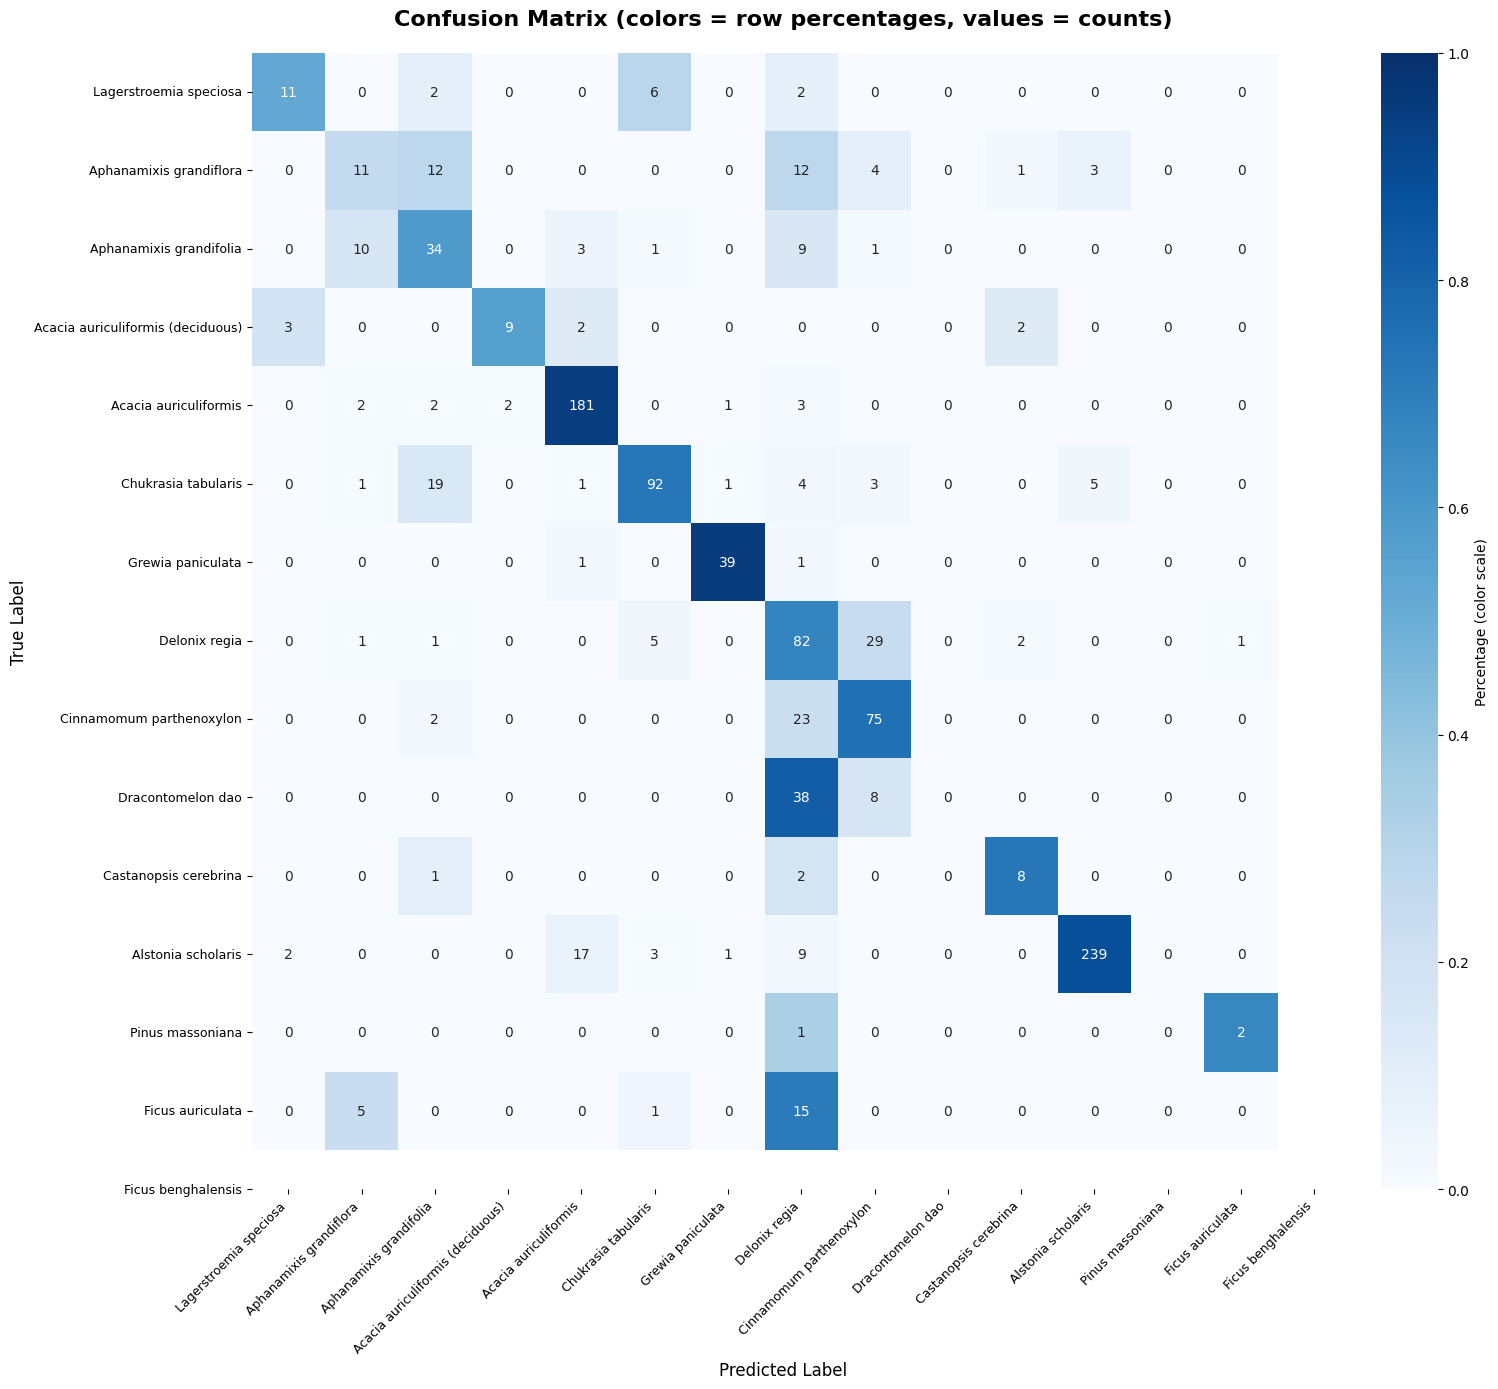

📊 Confusion matrix saved to test_confusion_matrix_global.png


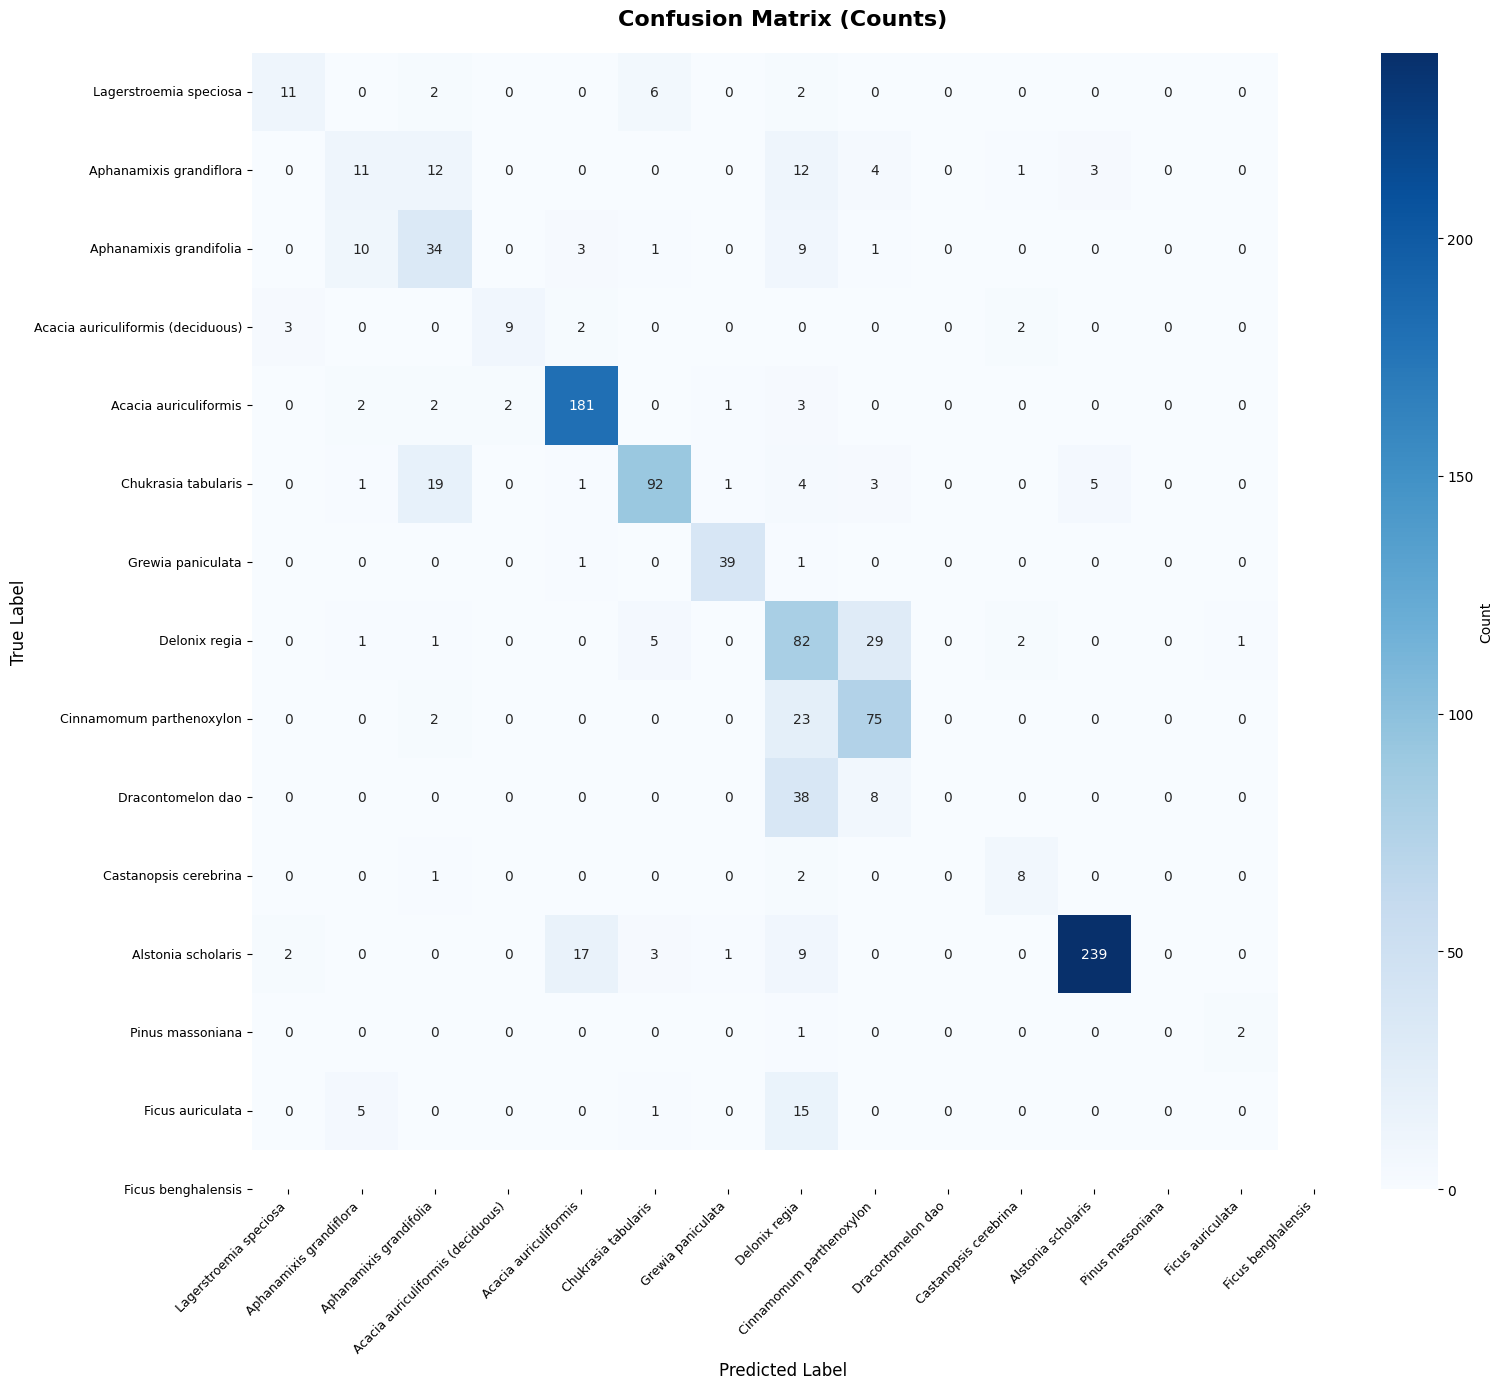


🎉 FINAL TEST RESULTS:
   Accuracy: 73.06%
   Precision: 54.41%
   Recall: 54.24%
   F1-Score: 53.59%


{'test_accuracy': 73.05893358278765,
 'test_precision': 54.41005835442551,
 'test_recall': 54.24450065810862,
 'test_f1_score': 53.589441941446395,
 'per_class_metrics': {'Bằng lăng': {'precision': 68.75,
   'recall': 52.38095238095239,
   'f1_score': 59.45945945945946,
   'support': 21},
  'Gội': {'precision': 36.666666666666664,
   'recall': 25.581395348837212,
   'f1_score': 30.136986301369863,
   'support': 43},
  'Gội trắng': {'precision': 46.57534246575342,
   'recall': 58.620689655172406,
   'f1_score': 51.908396946564885,
   'support': 58},
  'Keo Lá Tràm ( Rụng Lá)': {'precision': 81.81818181818183,
   'recall': 56.25,
   'f1_score': 66.66666666666666,
   'support': 16},
  'Keo lá tràm': {'precision': 88.29268292682927,
   'recall': 94.76439790575915,
   'f1_score': 91.41414141414141,
   'support': 191},
  'Lát Hoa': {'precision': 85.18518518518519,
   'recall': 73.01587301587301,
   'f1_score': 78.63247863247864,
   'support': 126},
  'Phượng vĩ': {'precision': 92.85714285714

In [38]:
TEST_DIR = "/content/Single/test"

# 2. Cell này dùng để Test riêng biệt
print("Running Testing Step...")

# Sử dụng model đã lưu từ lần train trước
model_path = f"Single_best_{DEFAULT_CONFIG['model_name']}.pth"
# model_path = "/content/drive/MyDrive/PlantIdentification/saved_models/Single_best_vit_base_patch16_224.pth"

# Chạy test
run_testing(model_path)

**1) VỚI TỆP 22/05**

In [16]:
!unzip /content/drive/MyDrive/PlantIdentification/Patches/VNUF_134_Patches.zip

Archive:  /content/drive/MyDrive/PlantIdentification/Patches/VNUF_134_Patches.zip
   creating: VNUF_134_Patches/
VNUF_134_Patches/Bằng lăng/:  mismatching "local" filename (VNUF_134_Patches/Bс║▒ng l─Гng/),
         continuing with "central" filename version
   creating: VNUF_134_Patches/Bằng lăng/
VNUF_134_Patches/Bằng lăng/248_patch1.png:  mismatching "local" filename (VNUF_134_Patches/Bс║▒ng l─Гng/248_patch1.png),
         continuing with "central" filename version
  inflating: VNUF_134_Patches/Bằng lăng/248_patch1.png  
VNUF_134_Patches/Bằng lăng/248_patch3.png:  mismatching "local" filename (VNUF_134_Patches/Bс║▒ng l─Гng/248_patch3.png),
         continuing with "central" filename version
  inflating: VNUF_134_Patches/Bằng lăng/248_patch3.png  
VNUF_134_Patches/Bằng lăng/248_patch4.png:  mismatching "local" filename (VNUF_134_Patches/Bс║▒ng l─Гng/248_patch4.png),
         continuing with "central" filename version
  inflating: VNUF_134_Patches/Bằng lăng/248_patch4.png  
VNUF_134_Pa

In [39]:
!rm -rf /content/VNUF_134_Patches/Sếu

Running Testing Step...
🚀 Starting Testing Process using model: Single_best_vit_base_patch16_224.pth...
Number of classes: 14
Using Focal Loss (alpha=1.0, gamma=2.0)
Adding Center Loss
Adding CORAL Loss
Model: vit_base_patch16_224
Device: cuda
Adding CenterLoss centers to optimizer
Loading model from Single_best_vit_base_patch16_224.pth

🧪 EVALUATING ON TEST SET


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.73it/s, Loss=14.8382, Acc=38.86%]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri


🎯 DETAILED TEST RESULTS
Overall Accuracy: 38.86%
Overall Precision (Macro): 19.71%
Overall Recall (Macro): 13.11%
Overall F1-Score (Macro): 12.41%

📊 PER-CLASS METRICS:
----------------------------------------------------------------------
Class                Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
Bằng lăng            0.00       % 0.00       % 0.00       % 7         
Gội                  20.00      % 4.55       % 7.41       % 44        
Gội trắng            7.32       % 6.67       % 6.98       % 45        
Keo Lá Tràm ( Rụng Lá) 0.00       % 0.00       % 0.00       % 11        
Keo lá tràm          44.11      % 96.41      % 60.53      % 167       
Lát Hoa              85.71      % 11.76      % 20.69      % 51        
Phượng vĩ            90.77      % 41.26      % 56.73      % 143       
Re hương             20.59      % 7.87       % 11.38      % 89        
Sấu                  7.48       % 15.09      % 

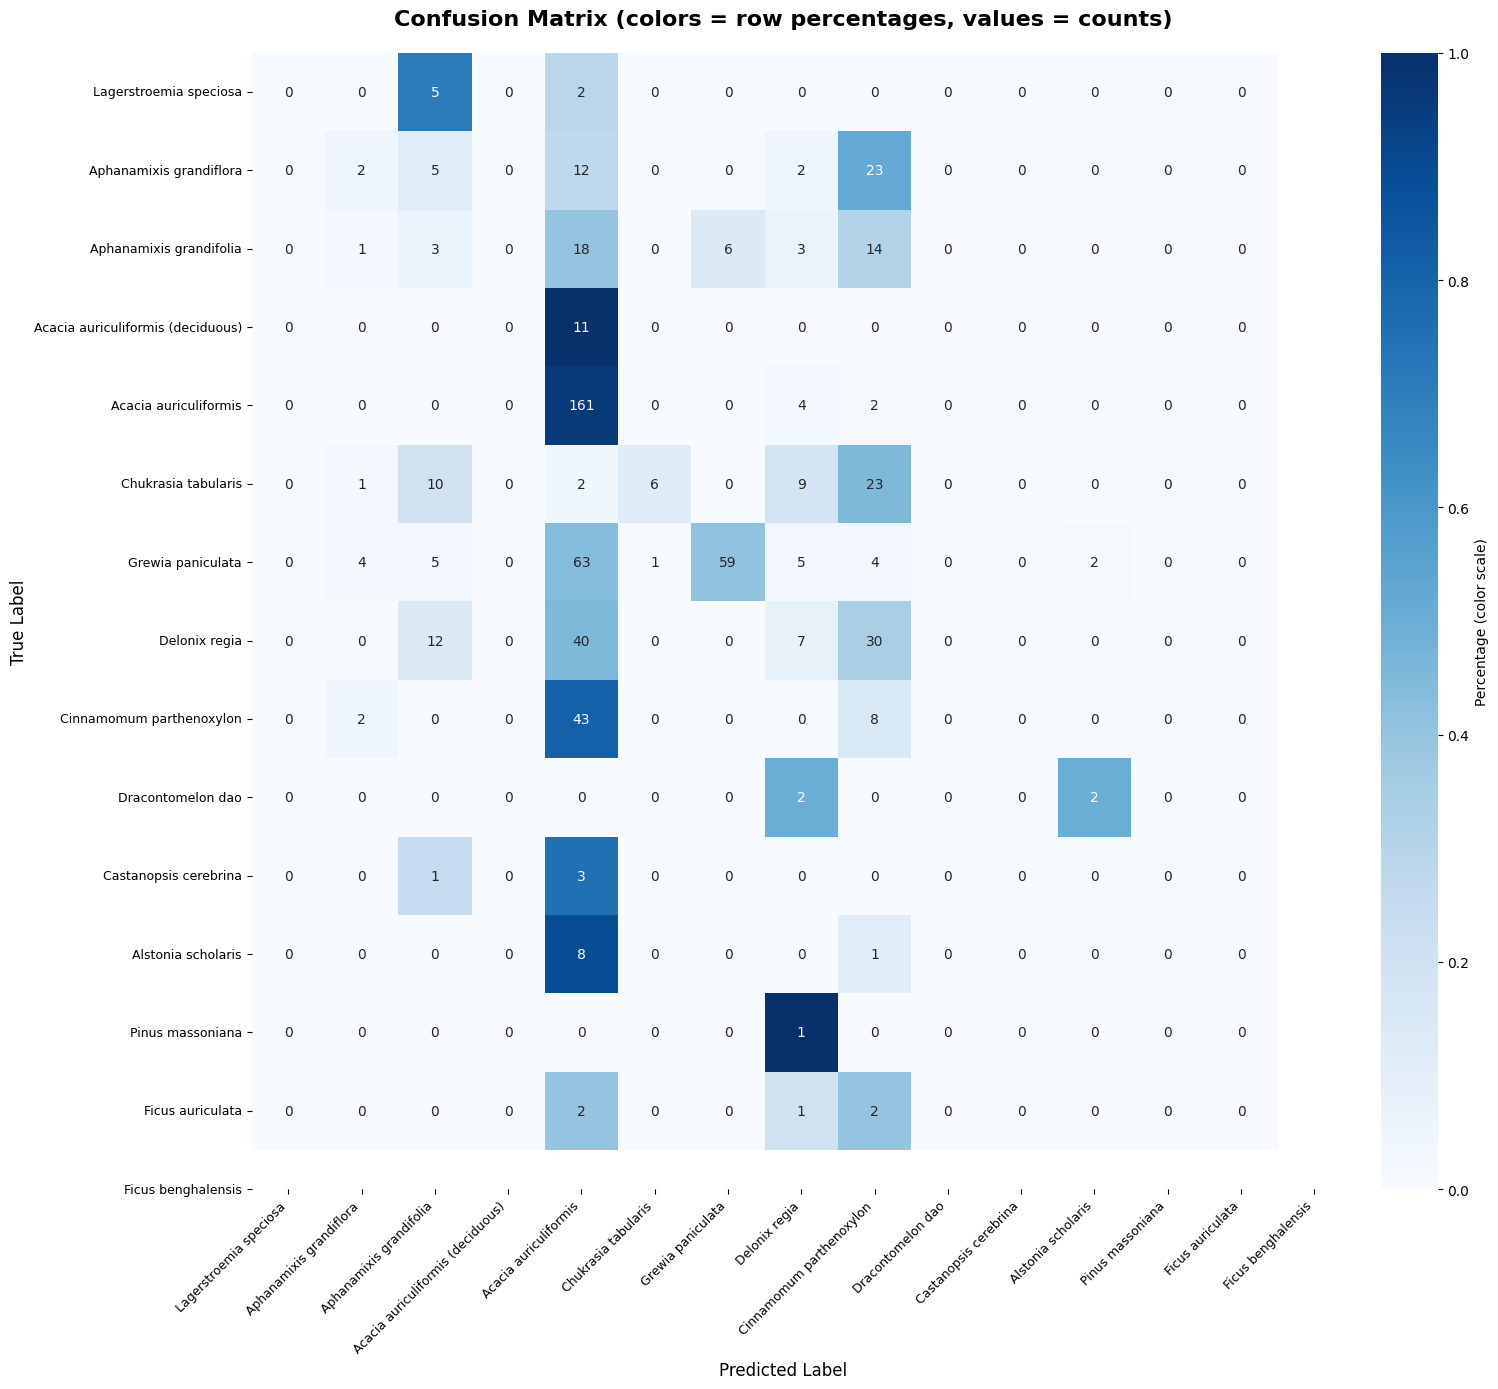

📊 Confusion matrix saved to test_confusion_matrix_global.png


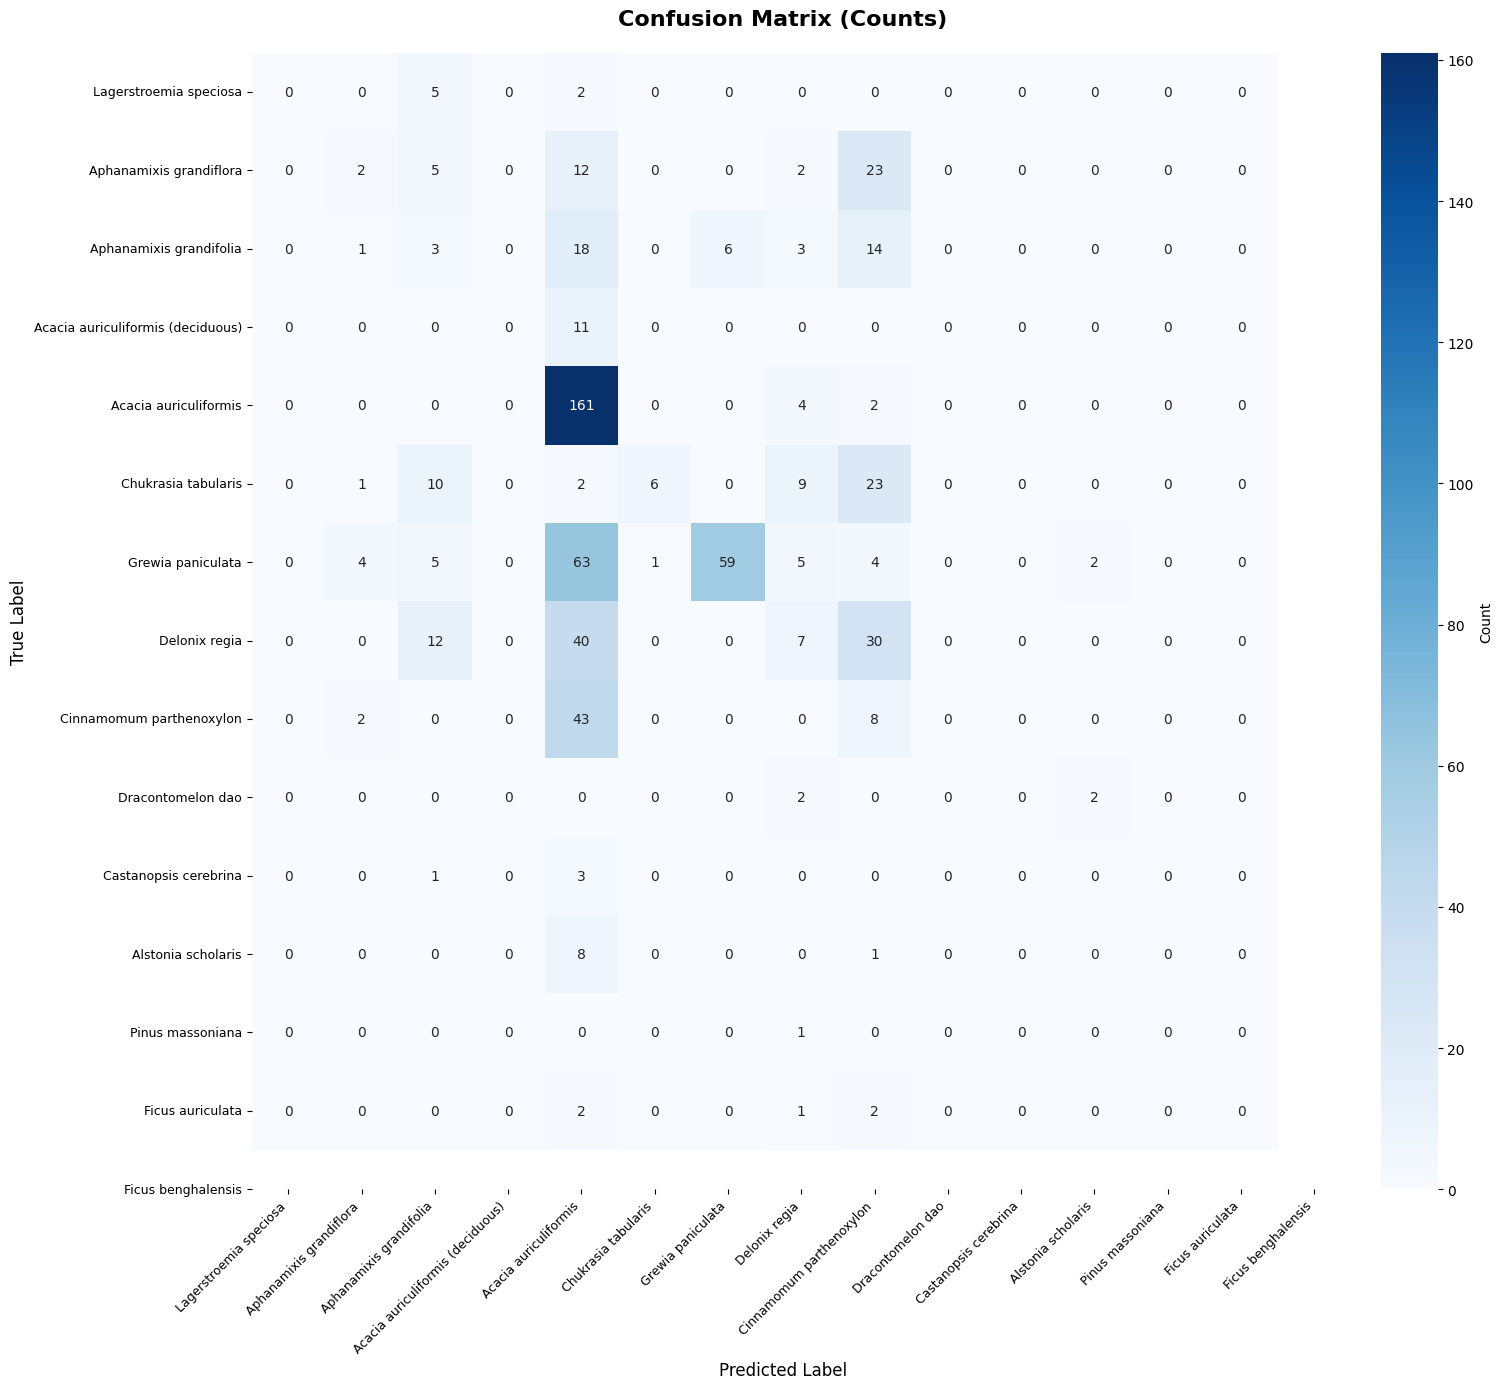


🎉 FINAL TEST RESULTS:
   Accuracy: 38.86%
   Precision: 19.71%
   Recall: 13.11%
   F1-Score: 12.41%


{'test_accuracy': 38.86255924170616,
 'test_precision': 19.71250353596289,
 'test_recall': 13.11444729599466,
 'test_f1_score': 12.408071829089204,
 'per_class_metrics': {'Bằng lăng': {'precision': 0.0,
   'recall': 0.0,
   'f1_score': 0.0,
   'support': 7},
  'Gội': {'precision': 20.0,
   'recall': 4.545454545454546,
   'f1_score': 7.4074074074074066,
   'support': 44},
  'Gội trắng': {'precision': 7.317073170731707,
   'recall': 6.666666666666667,
   'f1_score': 6.976744186046512,
   'support': 45},
  'Keo Lá Tràm ( Rụng Lá)': {'precision': 0.0,
   'recall': 0.0,
   'f1_score': 0.0,
   'support': 11},
  'Keo lá tràm': {'precision': 44.109589041095894,
   'recall': 96.40718562874252,
   'f1_score': 60.526315789473685,
   'support': 167},
  'Lát Hoa': {'precision': 85.71428571428571,
   'recall': 11.76470588235294,
   'f1_score': 20.689655172413794,
   'support': 51},
  'Phượng vĩ': {'precision': 90.76923076923077,
   'recall': 41.25874125874126,
   'f1_score': 56.730769230769226,
   '

In [40]:
TEST_DIR = "/content/VNUF_134_Patches"

# 2. Cell này dùng để Test riêng biệt
print("Running Testing Step...")

# Sử dụng model đã lưu từ lần train trước
model_path = f"Single_best_{DEFAULT_CONFIG['model_name']}.pth"
# model_path = "/content/drive/MyDrive/PlantIdentification/saved_models/Single_best_vit_base_patch16_224.pth"

# Chạy test
run_testing(model_path)

**2) VỚI TỆP 10/08**

In [19]:
!unzip /content/drive/MyDrive/PlantIdentification/Patches/VNUF_234_Patches.zip

Streaming output truncated to the last 5000 lines.
         continuing with "central" filename version
  inflating: VNUF_234_Patches/Gội trắng/233_patch2.png  
VNUF_234_Patches/Gội trắng/279_patch1.png:  mismatching "local" filename (VNUF_234_Patches/Gс╗Щi trс║пng/279_patch1.png),
         continuing with "central" filename version
  inflating: VNUF_234_Patches/Gội trắng/279_patch1.png  
VNUF_234_Patches/Gội trắng/279_patch2.png:  mismatching "local" filename (VNUF_234_Patches/Gс╗Щi trс║пng/279_patch2.png),
         continuing with "central" filename version
  inflating: VNUF_234_Patches/Gội trắng/279_patch2.png  
VNUF_234_Patches/Gội trắng/284_patch1.png:  mismatching "local" filename (VNUF_234_Patches/Gс╗Щi trс║пng/284_patch1.png),
         continuing with "central" filename version
  inflating: VNUF_234_Patches/Gội trắng/284_patch1.png  
VNUF_234_Patches/Gội trắng/284_patch10.png:  mismatching "local" filename (VNUF_234_Patches/Gс╗Щi trс║пng/284_patch10.png),
         continuing wit

In [41]:
!rm -rf /content/VNUF_234_Patches/Sếu

In [42]:
TEST_DIR = "/content/VNUF_234_Patches"

def run_testing(model_path, config=DEFAULT_CONFIG):
    """Run testing process separately"""
    print(f"🚀 Starting Testing Process using model: {model_path}...")

    if not os.path.exists(model_path):
        print(f"❌ Model path not found: {model_path}")
        return

    # Initialize trainer (for dataloaders and model structure)
    trainer = ModelTrainer(
        train_dir=TRAIN_DIR,
        val_dir=VAL_DIR,
        test_dir=TEST_DIR,
        **config
    )

    # Evaluate on test set
    test_predicted, test_labels, metrics = trainer.evaluate_on_test(model_path)

    # Plot confusion matrix with scientific names
    plot_confusion_matrix(
        test_labels,
        test_predicted,
        trainer.class_names,
        save_path='test_confusion_matrix.png',
        scientific_names=SCIENTIFIC_NAMES,
        normalize_per_row=True
    )

    # Global scale confusion matrix
    plot_confusion_matrix(
        test_labels,
        test_predicted,
        trainer.class_names,
        save_path='test_confusion_matrix_global.png',
        scientific_names=SCIENTIFIC_NAMES,
        normalize_per_row=False
    )

    # Print final results
    print(f"\n🎉 FINAL TEST RESULTS:")
    print(f"   Accuracy: {metrics['test_accuracy']:.2f}%")
    print(f"   Precision: {metrics['test_precision']:.2f}%")
    print(f"   Recall: {metrics['test_recall']:.2f}%")
    print(f"   F1-Score: {metrics['test_f1_score']:.2f}%")

    return metrics

Running Testing Step...
🚀 Starting Testing Process using model: Single_best_vit_base_patch16_224.pth...
Number of classes: 14
Using Focal Loss (alpha=1.0, gamma=2.0)
Adding Center Loss
Adding CORAL Loss
Model: vit_base_patch16_224
Device: cuda
Adding CenterLoss centers to optimizer
Loading model from Single_best_vit_base_patch16_224.pth

🧪 EVALUATING ON TEST SET


Testing: 100%|██████████| 37/37 [00:12<00:00,  2.87it/s, Loss=13.6310, Acc=56.29%]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri


🎯 DETAILED TEST RESULTS
Overall Accuracy: 56.29%
Overall Precision (Macro): 44.86%
Overall Recall (Macro): 37.28%
Overall F1-Score (Macro): 36.52%

📊 PER-CLASS METRICS:
----------------------------------------------------------------------
Class                Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
Bằng lăng            100.00     % 29.03      % 45.00      % 31        
Gội                  41.76      % 32.48      % 36.54      % 117       
Gội trắng            26.57      % 73.55      % 39.04      % 121       
Keo Lá Tràm ( Rụng Lá) 78.57      % 91.67      % 84.62      % 24        
Keo lá tràm          94.94      % 68.38      % 79.50      % 604       
Lát Hoa              45.51      % 34.80      % 39.44      % 204       
Phượng vĩ            73.91      % 9.88       % 17.44      % 172       
Re hương             38.65      % 68.75      % 49.48      % 416       
Sấu                  39.90      % 35.84      % 

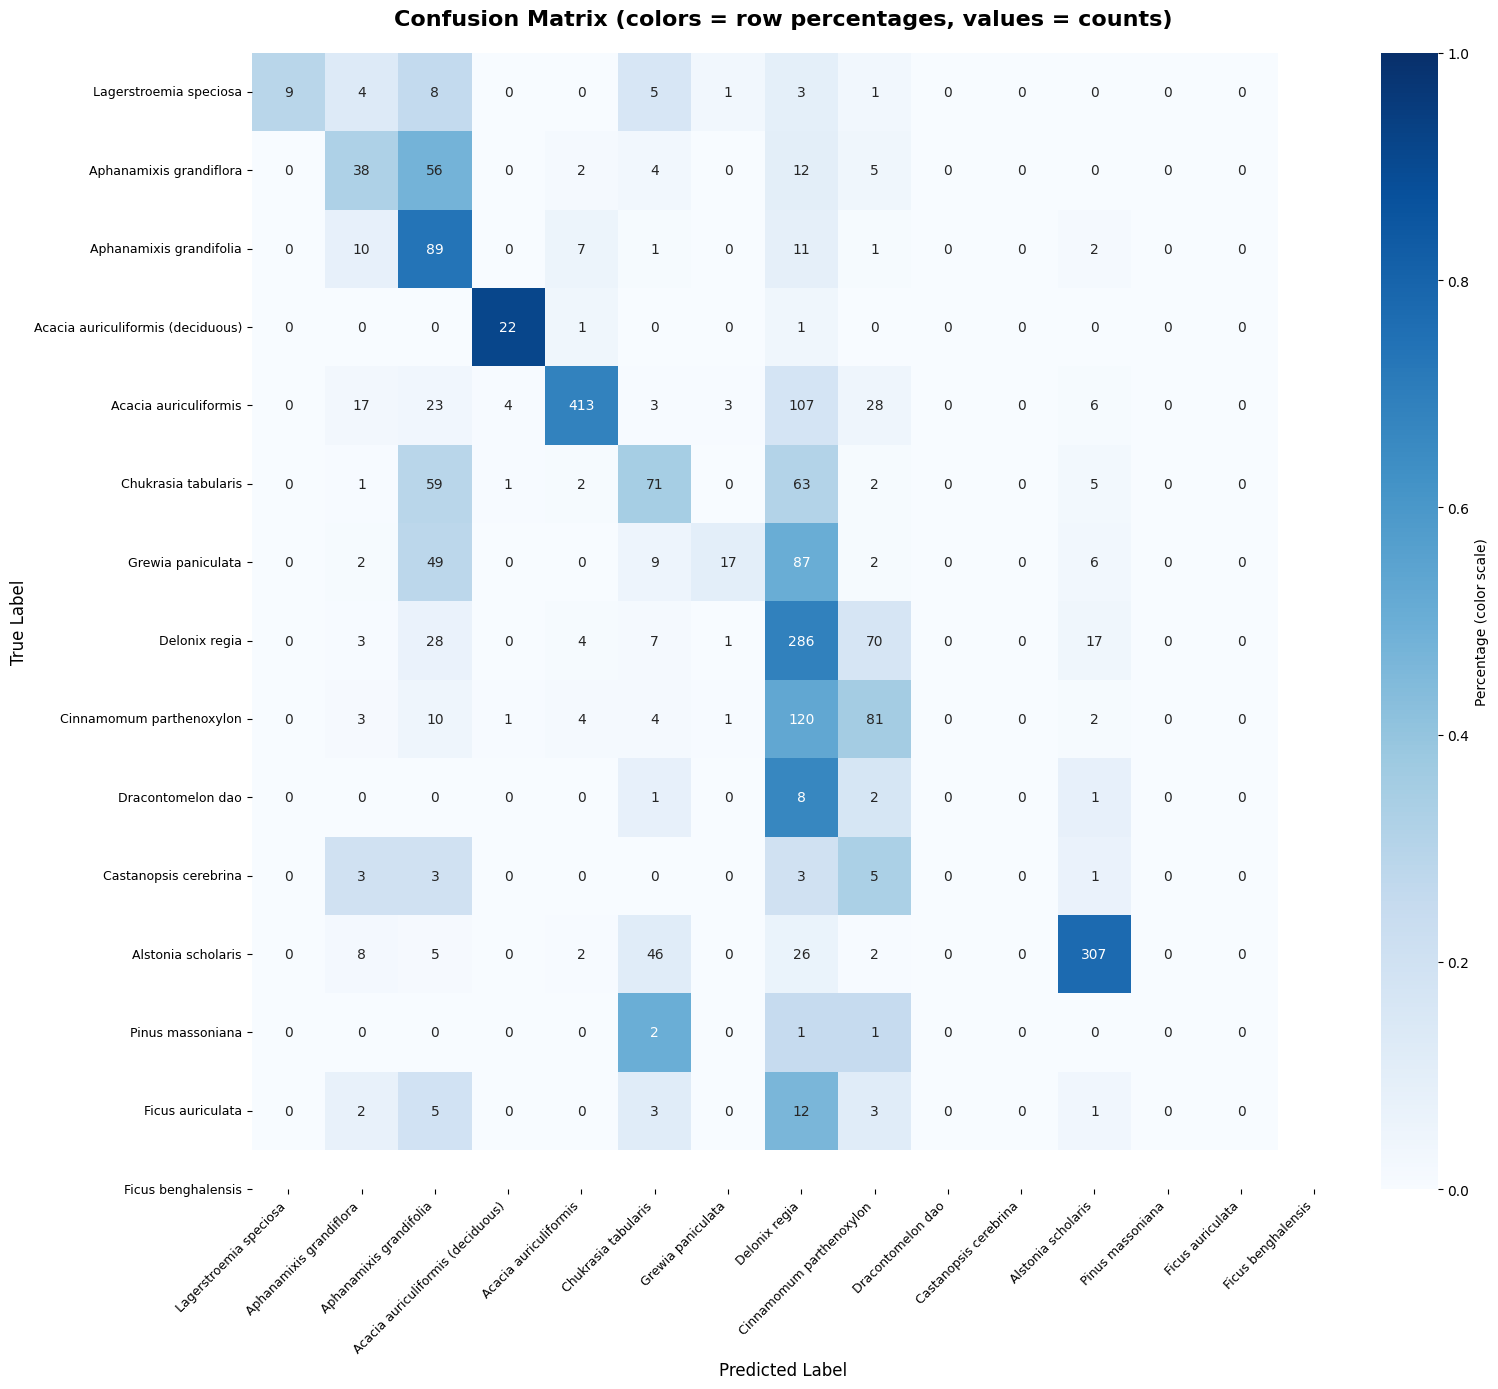

📊 Confusion matrix saved to test_confusion_matrix_global.png


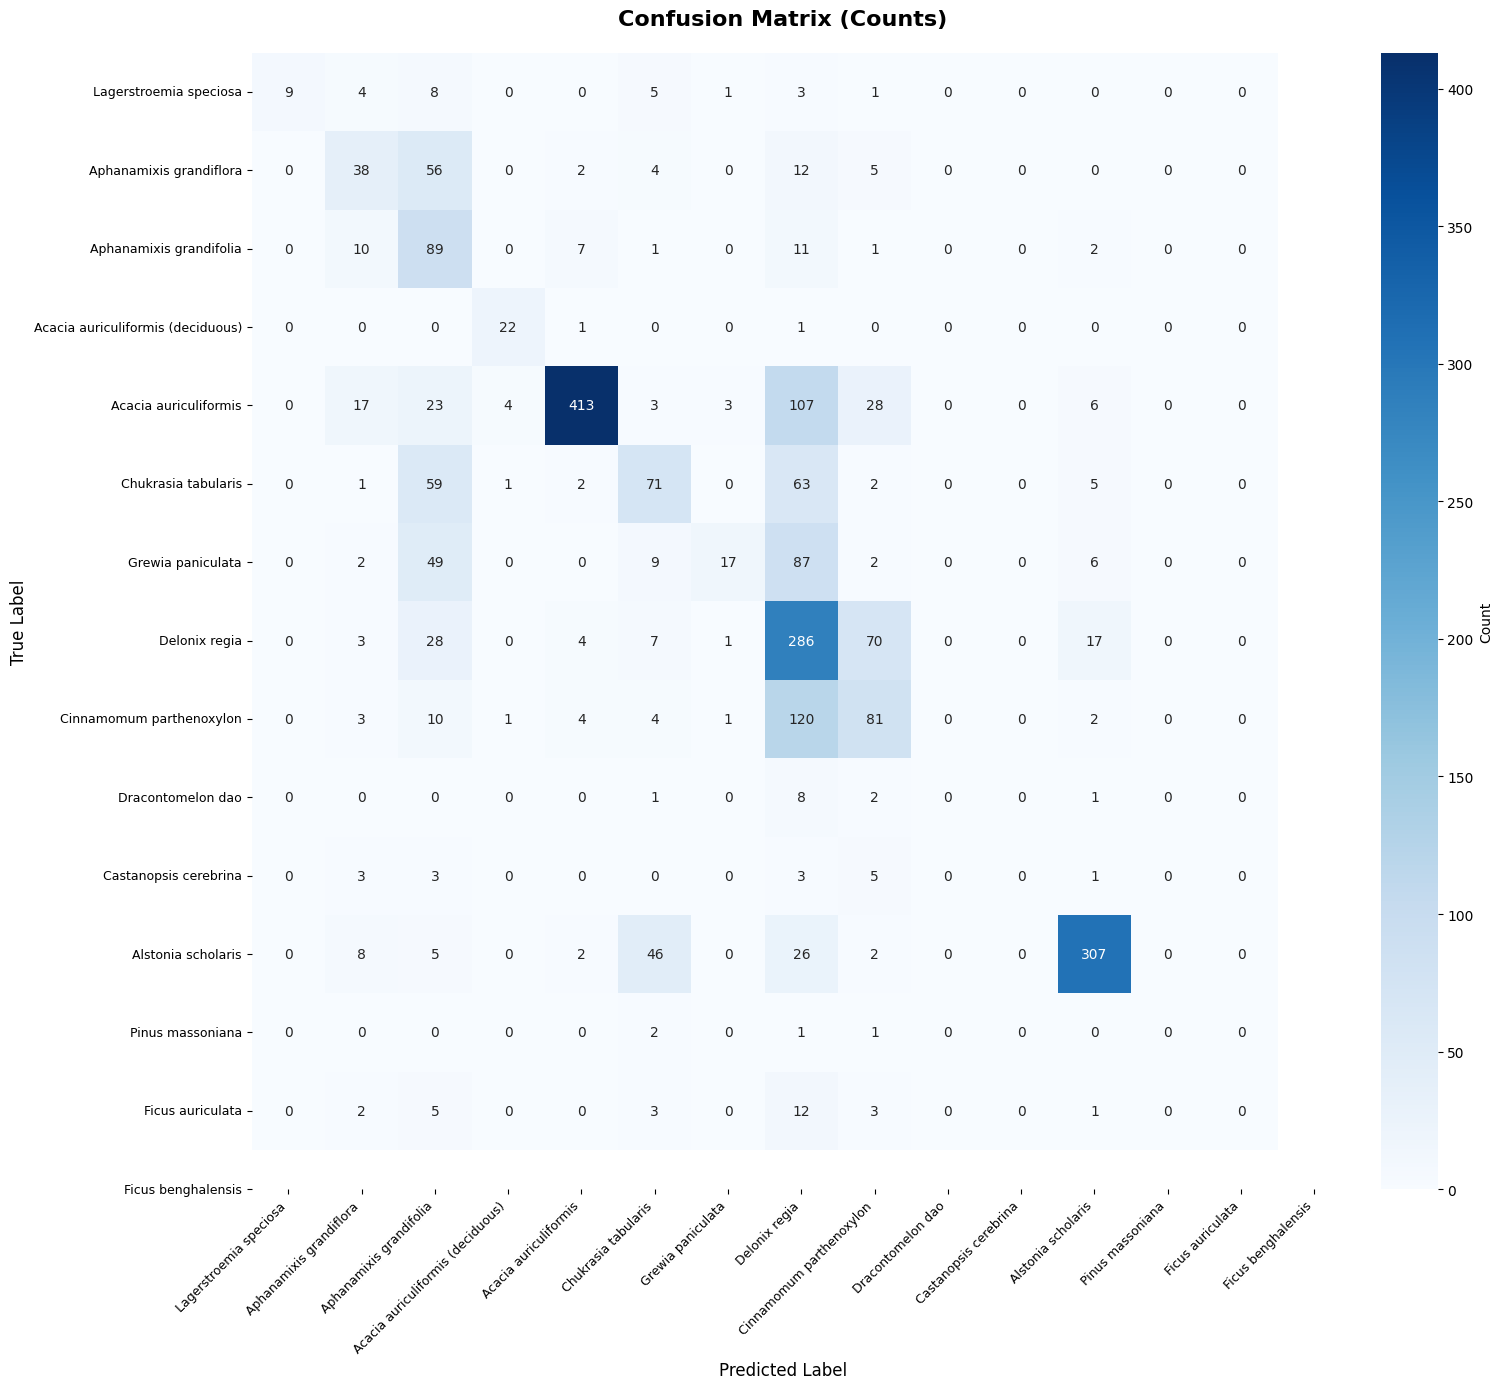


🎉 FINAL TEST RESULTS:
   Accuracy: 56.29%
   Precision: 44.86%
   Recall: 37.28%
   F1-Score: 36.52%


{'test_accuracy': 56.292229729729726,
 'test_precision': 44.85955318008908,
 'test_recall': 37.2794544750359,
 'test_f1_score': 36.524205918737984,
 'per_class_metrics': {'Bằng lăng': {'precision': 100.0,
   'recall': 29.03225806451613,
   'f1_score': 45.0,
   'support': 31},
  'Gội': {'precision': 41.75824175824176,
   'recall': 32.47863247863248,
   'f1_score': 36.53846153846153,
   'support': 117},
  'Gội trắng': {'precision': 26.56716417910448,
   'recall': 73.55371900826447,
   'f1_score': 39.03508771929825,
   'support': 121},
  'Keo Lá Tràm ( Rụng Lá)': {'precision': 78.57142857142857,
   'recall': 91.66666666666666,
   'f1_score': 84.61538461538461,
   'support': 24},
  'Keo lá tràm': {'precision': 94.94252873563218,
   'recall': 68.37748344370861,
   'f1_score': 79.4995187680462,
   'support': 604},
  'Lát Hoa': {'precision': 45.51282051282051,
   'recall': 34.80392156862745,
   'f1_score': 39.44444444444444,
   'support': 204},
  'Phượng vĩ': {'precision': 73.91304347826086,


In [43]:
TEST_DIR = "/content/VNUF_234_Patches"
# 2. Cell này dùng để Test riêng biệt
print("Running Testing Step...")

# Sử dụng model đã lưu từ lần train trước
model_path = f"Single_best_{DEFAULT_CONFIG['model_name']}.pth"
# model_path = "/content/drive/MyDrive/PlantIdentification/saved_models/Single_best_vit_base_patch16_224.pth"

# Chạy test
run_testing(model_path)

**3) VỚI TỆP 24/08 CAMERA 1X**

In [23]:
!unzip /content/drive/MyDrive/PlantIdentification/Patches/VNUF_299_Patches.zip

Streaming output truncated to the last 5000 lines.
         continuing with "central" filename version
  inflating: VNUF_299_Patches/Sấu/88_patch27.png  
VNUF_299_Patches/Sấu/88_patch28.png:  mismatching "local" filename (VNUF_299_Patches/Sс║еu/88_patch28.png),
         continuing with "central" filename version
  inflating: VNUF_299_Patches/Sấu/88_patch28.png  
VNUF_299_Patches/Sấu/88_patch29.png:  mismatching "local" filename (VNUF_299_Patches/Sс║еu/88_patch29.png),
         continuing with "central" filename version
  inflating: VNUF_299_Patches/Sấu/88_patch29.png  
VNUF_299_Patches/Sấu/88_patch3.png:  mismatching "local" filename (VNUF_299_Patches/Sс║еu/88_patch3.png),
         continuing with "central" filename version
  inflating: VNUF_299_Patches/Sấu/88_patch3.png  
VNUF_299_Patches/Sấu/88_patch30.png:  mismatching "local" filename (VNUF_299_Patches/Sс║еu/88_patch30.png),
         continuing with "central" filename version
  inflating: VNUF_299_Patches/Sấu/88_patch30.png  
VNUF_

In [44]:
!rm -rf /content/VNUF_299_Patches/Sếu

Running Testing Step...
🚀 Starting Testing Process using model: Single_best_vit_base_patch16_224.pth...
Number of classes: 14
Using Focal Loss (alpha=1.0, gamma=2.0)
Adding Center Loss
Adding CORAL Loss
Model: vit_base_patch16_224
Device: cuda
Adding CenterLoss centers to optimizer
Loading model from Single_best_vit_base_patch16_224.pth

🧪 EVALUATING ON TEST SET


Testing: 100%|██████████| 116/116 [00:39<00:00,  2.94it/s, Loss=17.4871, Acc=71.97%]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{met


🎯 DETAILED TEST RESULTS
Overall Accuracy: 71.97%
Overall Precision (Macro): 61.19%
Overall Recall (Macro): 50.39%
Overall F1-Score (Macro): 51.61%

📊 PER-CLASS METRICS:
----------------------------------------------------------------------
Class                Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
Bằng lăng            83.08      % 50.47      % 62.79      % 107       
Gội                  61.41      % 48.48      % 54.18      % 394       
Gội trắng            38.53      % 71.76      % 50.14      % 386       
Keo Lá Tràm ( Rụng Lá) 83.53      % 77.17      % 80.23      % 92        
Keo lá tràm          87.88      % 91.19      % 89.50      % 1669      
Lát Hoa              84.49      % 62.87      % 72.09      % 676       
Phượng vĩ            97.88      % 77.35      % 86.41      % 596       
Re hương             51.54      % 79.31      % 62.48      % 1184      
Sấu                  54.10      % 23.89      % 

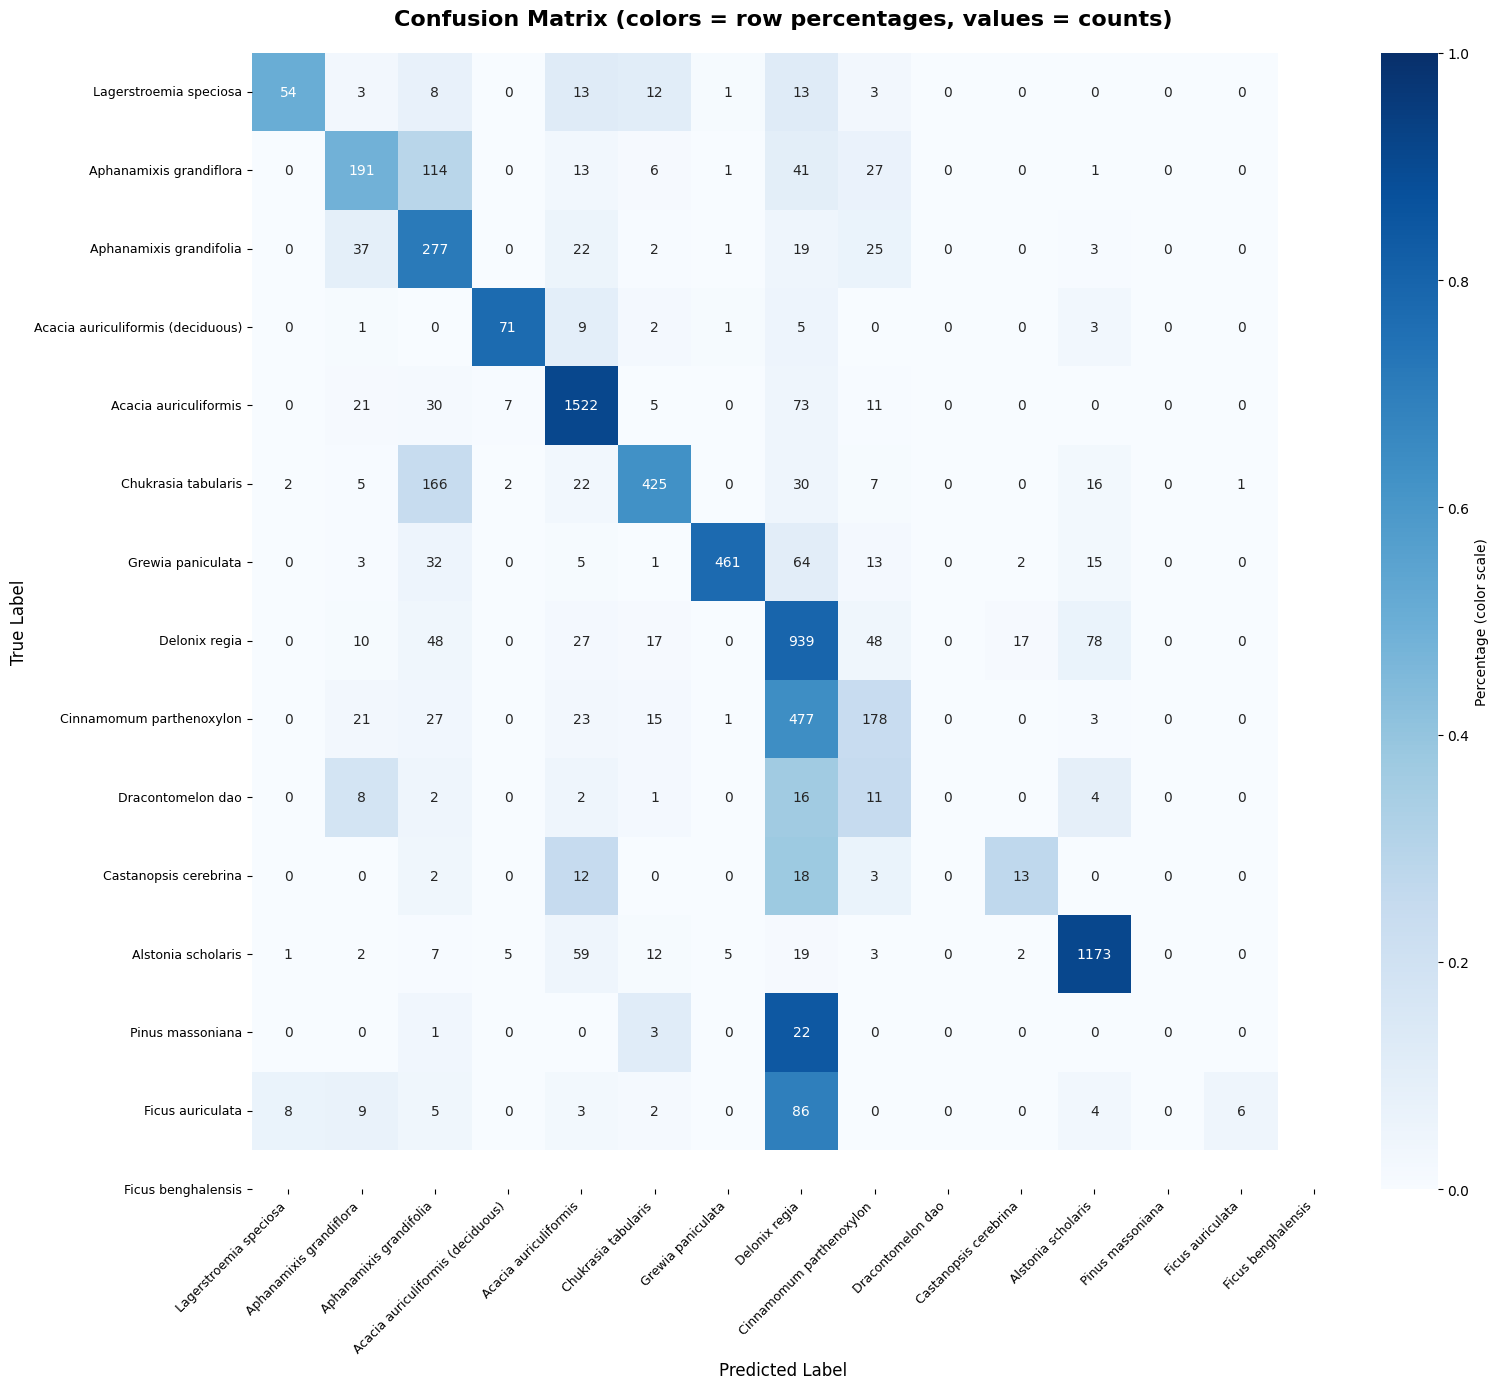

📊 Confusion matrix saved to test_confusion_matrix_global.png


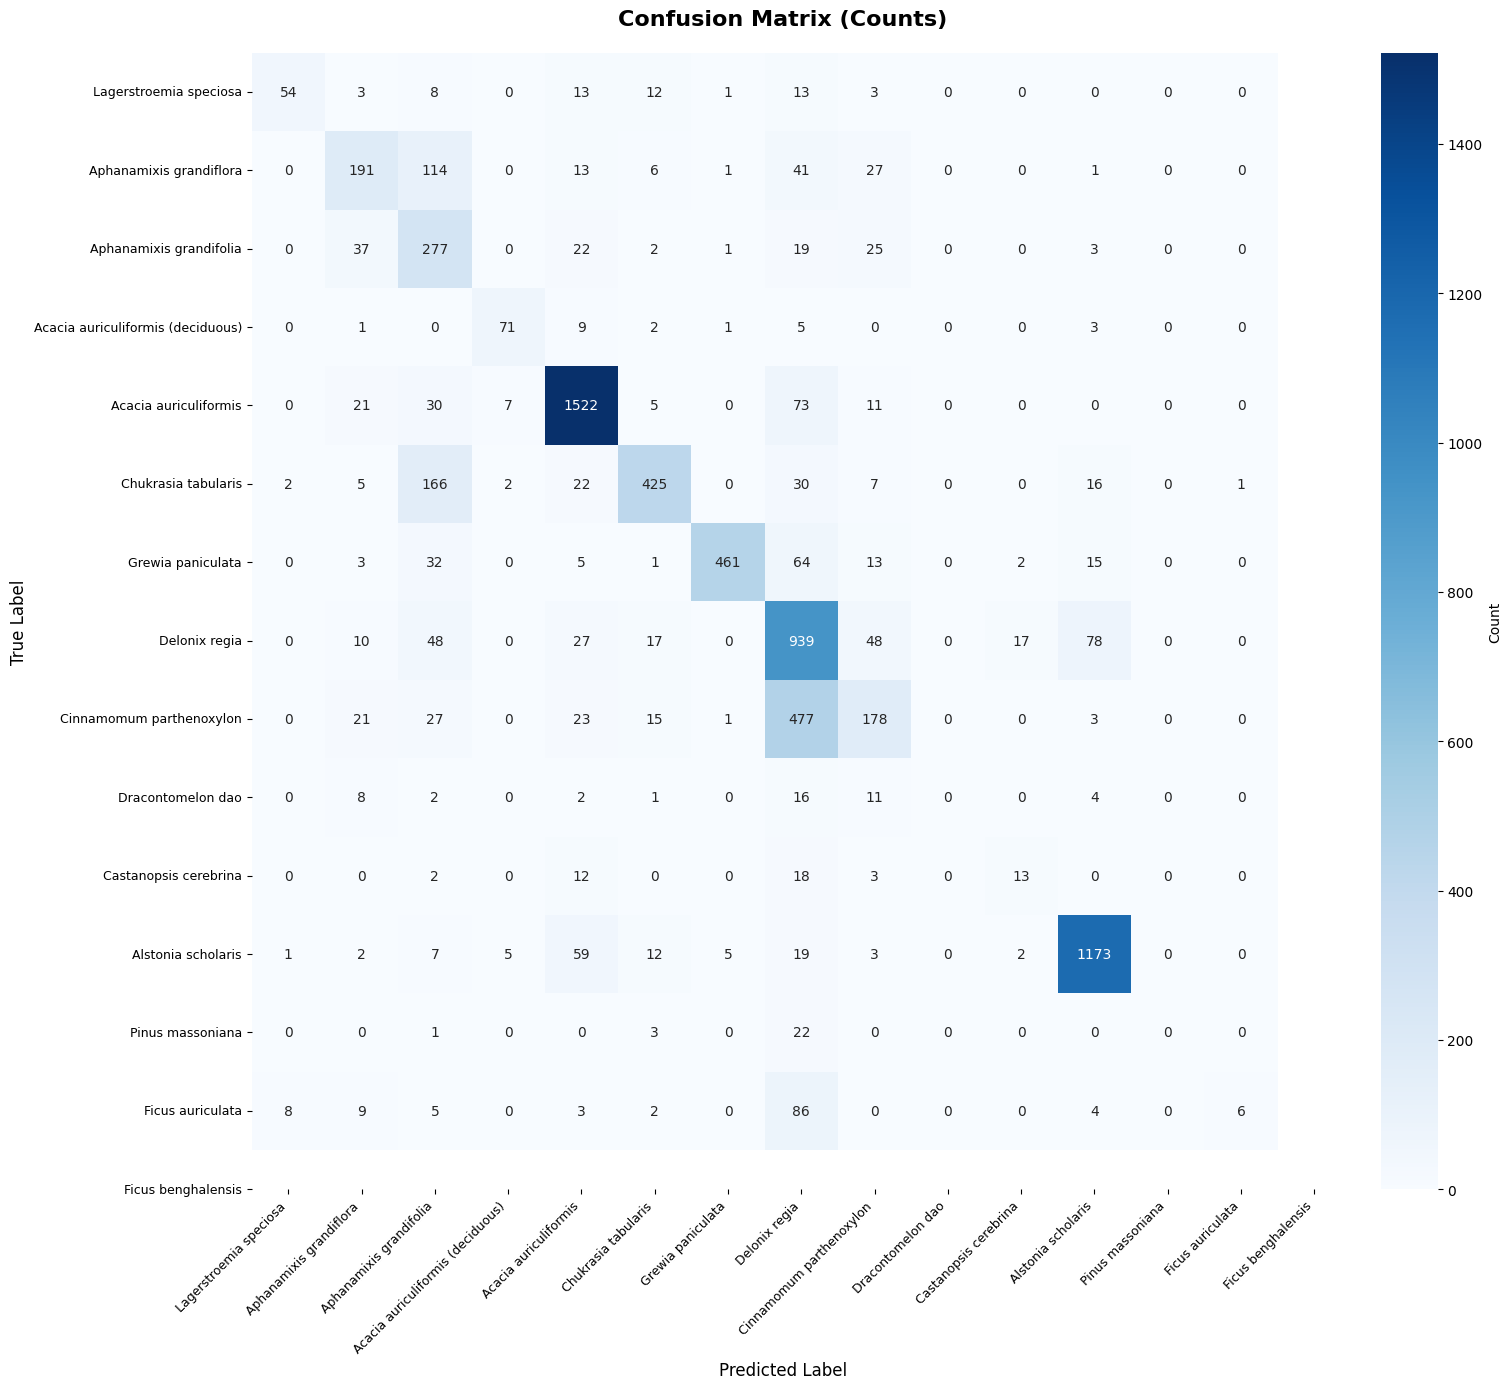


🎉 FINAL TEST RESULTS:
   Accuracy: 71.97%
   Precision: 61.19%
   Recall: 50.39%
   F1-Score: 51.61%


{'test_accuracy': 71.97072377338031,
 'test_precision': 61.18660782190791,
 'test_recall': 50.39457323090794,
 'test_f1_score': 51.61105783367782,
 'per_class_metrics': {'Bằng lăng': {'precision': 83.07692307692308,
   'recall': 50.467289719626166,
   'f1_score': 62.7906976744186,
   'support': 107},
  'Gội': {'precision': 61.41479099678456,
   'recall': 48.47715736040609,
   'f1_score': 54.184397163120565,
   'support': 394},
  'Gội trắng': {'precision': 38.525730180806676,
   'recall': 71.76165803108809,
   'f1_score': 50.13574660633484,
   'support': 386},
  'Keo Lá Tràm ( Rụng Lá)': {'precision': 83.52941176470588,
   'recall': 77.17391304347827,
   'f1_score': 80.22598870056498,
   'support': 92},
  'Keo lá tràm': {'precision': 87.87528868360278,
   'recall': 91.19233073696824,
   'f1_score': 89.5030873272567,
   'support': 1669},
  'Lát Hoa': {'precision': 84.49304174950298,
   'recall': 62.8698224852071,
   'f1_score': 72.0949957591179,
   'support': 676},
  'Phượng vĩ': {'preci

In [45]:
TEST_DIR = "/content/VNUF_299_Patches"
# 2. Cell này dùng để Test riêng biệt
print("Running Testing Step...")

# Sử dụng model đã lưu từ lần train trước
model_path = f"Single_best_{DEFAULT_CONFIG['model_name']}.pth"
# model_path = "/content/drive/MyDrive/PlantIdentification/saved_models/Single_best_vit_base_patch16_224.pth"

# Chạy test
run_testing(model_path)

In [26]:
!unzip /content/drive/MyDrive/PlantIdentification/Patches/100_0865_0040_modified_patches.zip

Archive:  /content/drive/MyDrive/PlantIdentification/Patches/100_0865_0040_modified_patches.zip
   creating: 100_0865_0040_modified_patches/
100_0865_0040_modified_patches/Bằng lăng/:  mismatching "local" filename (100_0865_0040_modified_patches/Bс║▒ng l─Гng/),
         continuing with "central" filename version
   creating: 100_0865_0040_modified_patches/Bằng lăng/
100_0865_0040_modified_patches/Bằng lăng/18_patch1.png:  mismatching "local" filename (100_0865_0040_modified_patches/Bс║▒ng l─Гng/18_patch1.png),
         continuing with "central" filename version
  inflating: 100_0865_0040_modified_patches/Bằng lăng/18_patch1.png  
100_0865_0040_modified_patches/Bằng lăng/18_patch2.png:  mismatching "local" filename (100_0865_0040_modified_patches/Bс║▒ng l─Гng/18_patch2.png),
         continuing with "central" filename version
  inflating: 100_0865_0040_modified_patches/Bằng lăng/18_patch2.png  
100_0865_0040_modified_patches/Bằng lăng/1_patch1.png:  mismatching "local" filename (100_086

In [ ]:
# !rm -rf /content/VNUF_299_Patches/Sếu

Running Testing Step...
🚀 Starting Testing Process using model: Single_best_vit_base_patch16_224.pth...
Number of classes: 14
Using Focal Loss (alpha=1.0, gamma=2.0)
Adding Center Loss
Adding CORAL Loss
Model: vit_base_patch16_224
Device: cuda
Adding CenterLoss centers to optimizer
Loading model from Single_best_vit_base_patch16_224.pth

🧪 EVALUATING ON TEST SET


Testing: 100%|██████████| 7/7 [00:02<00:00,  2.65it/s, Loss=14.8589, Acc=46.68%]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.


🎯 DETAILED TEST RESULTS
Overall Accuracy: 46.68%
Overall Precision (Macro): 13.79%
Overall Recall (Macro): 17.08%
Overall F1-Score (Macro): 13.29%

📊 PER-CLASS METRICS:
----------------------------------------------------------------------
Class                Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
Bằng lăng            0.00       % 0.00       % 0.00       % 9         
Gội                  13.04      % 21.43      % 16.22      % 14        
Gội trắng            18.00      % 52.94      % 26.87      % 17        
Keo Lá Tràm ( Rụng Lá) 0.00       % 0.00       % 0.00       % 9         
Keo lá tràm          50.22      % 88.46      % 64.07      % 130       
Lát Hoa              0.00       % 0.00       % 0.00       % 9         
Phượng vĩ            94.12      % 38.79      % 54.94      % 165       
Re hương             0.00       % 0.00       % 0.00       % 26        
Sấu                  17.65      % 37.50      % 

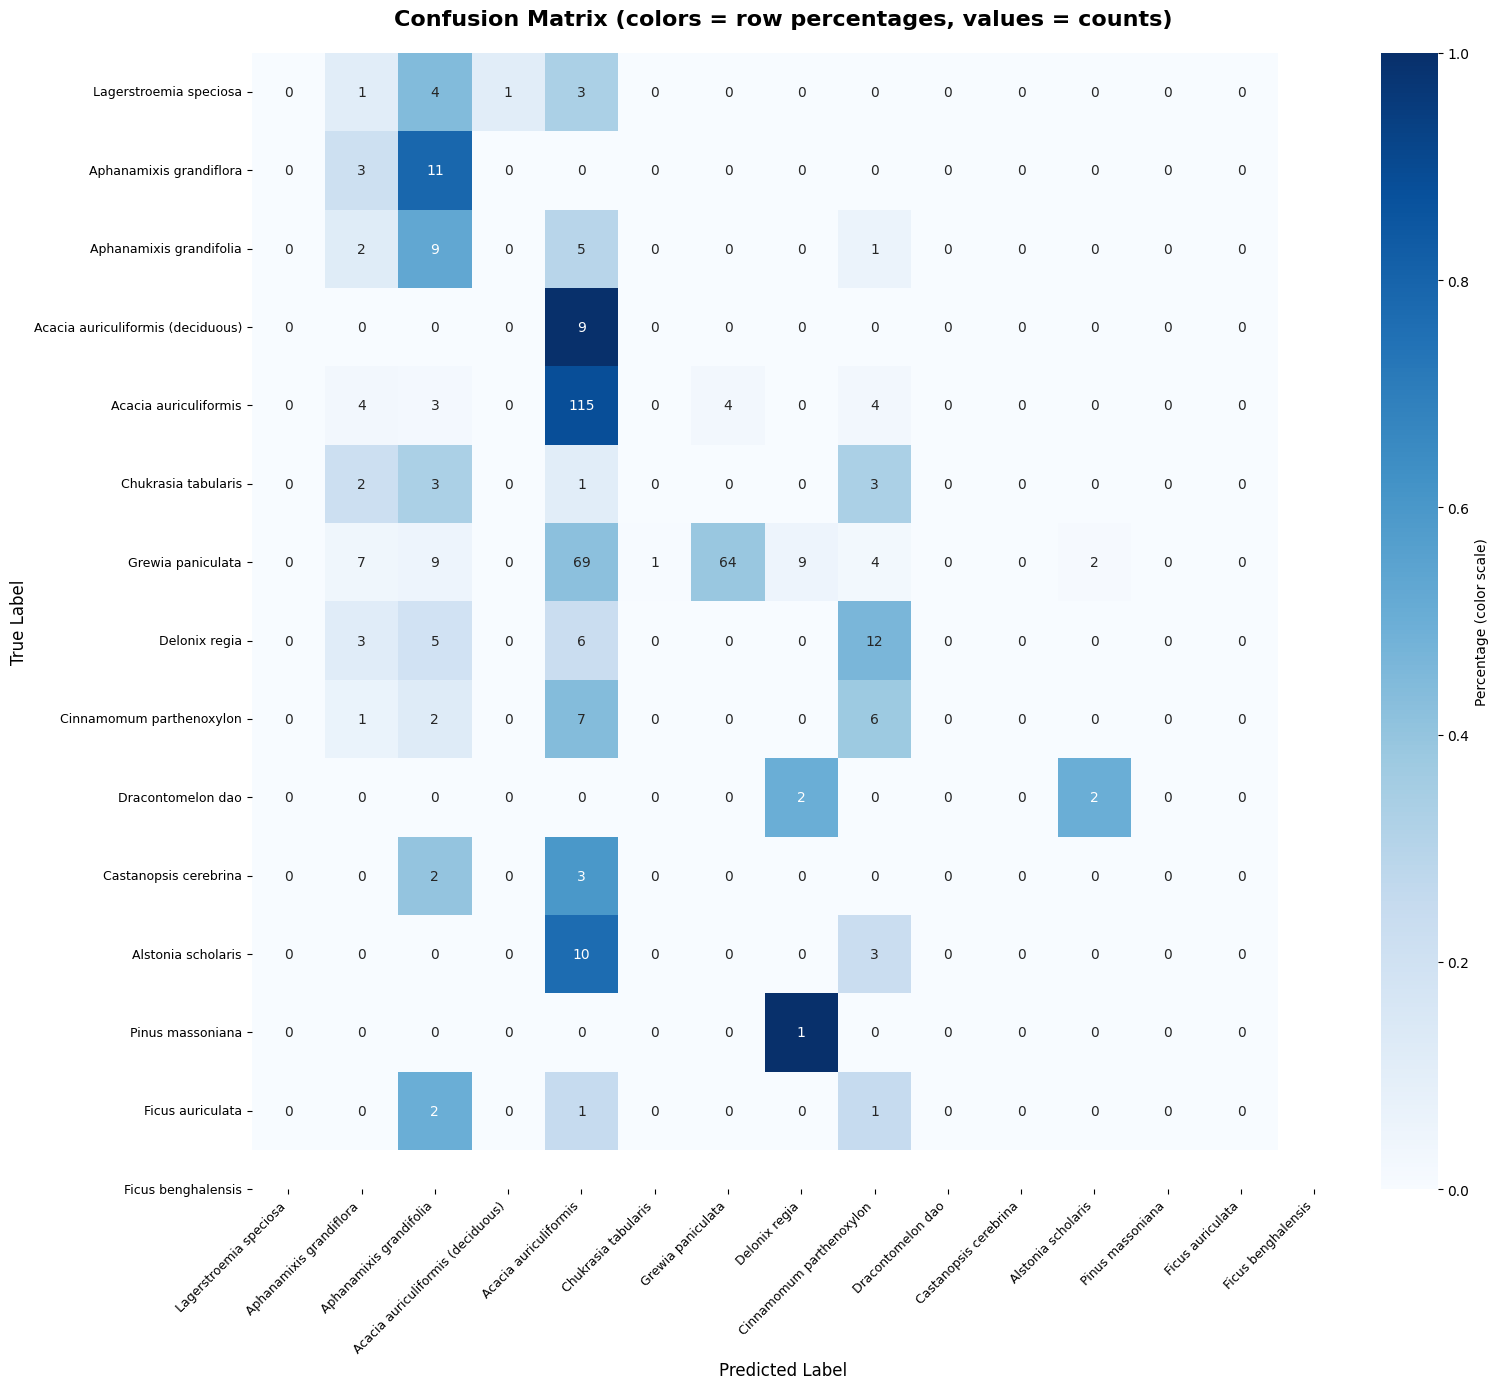

📊 Confusion matrix saved to test_confusion_matrix_global.png


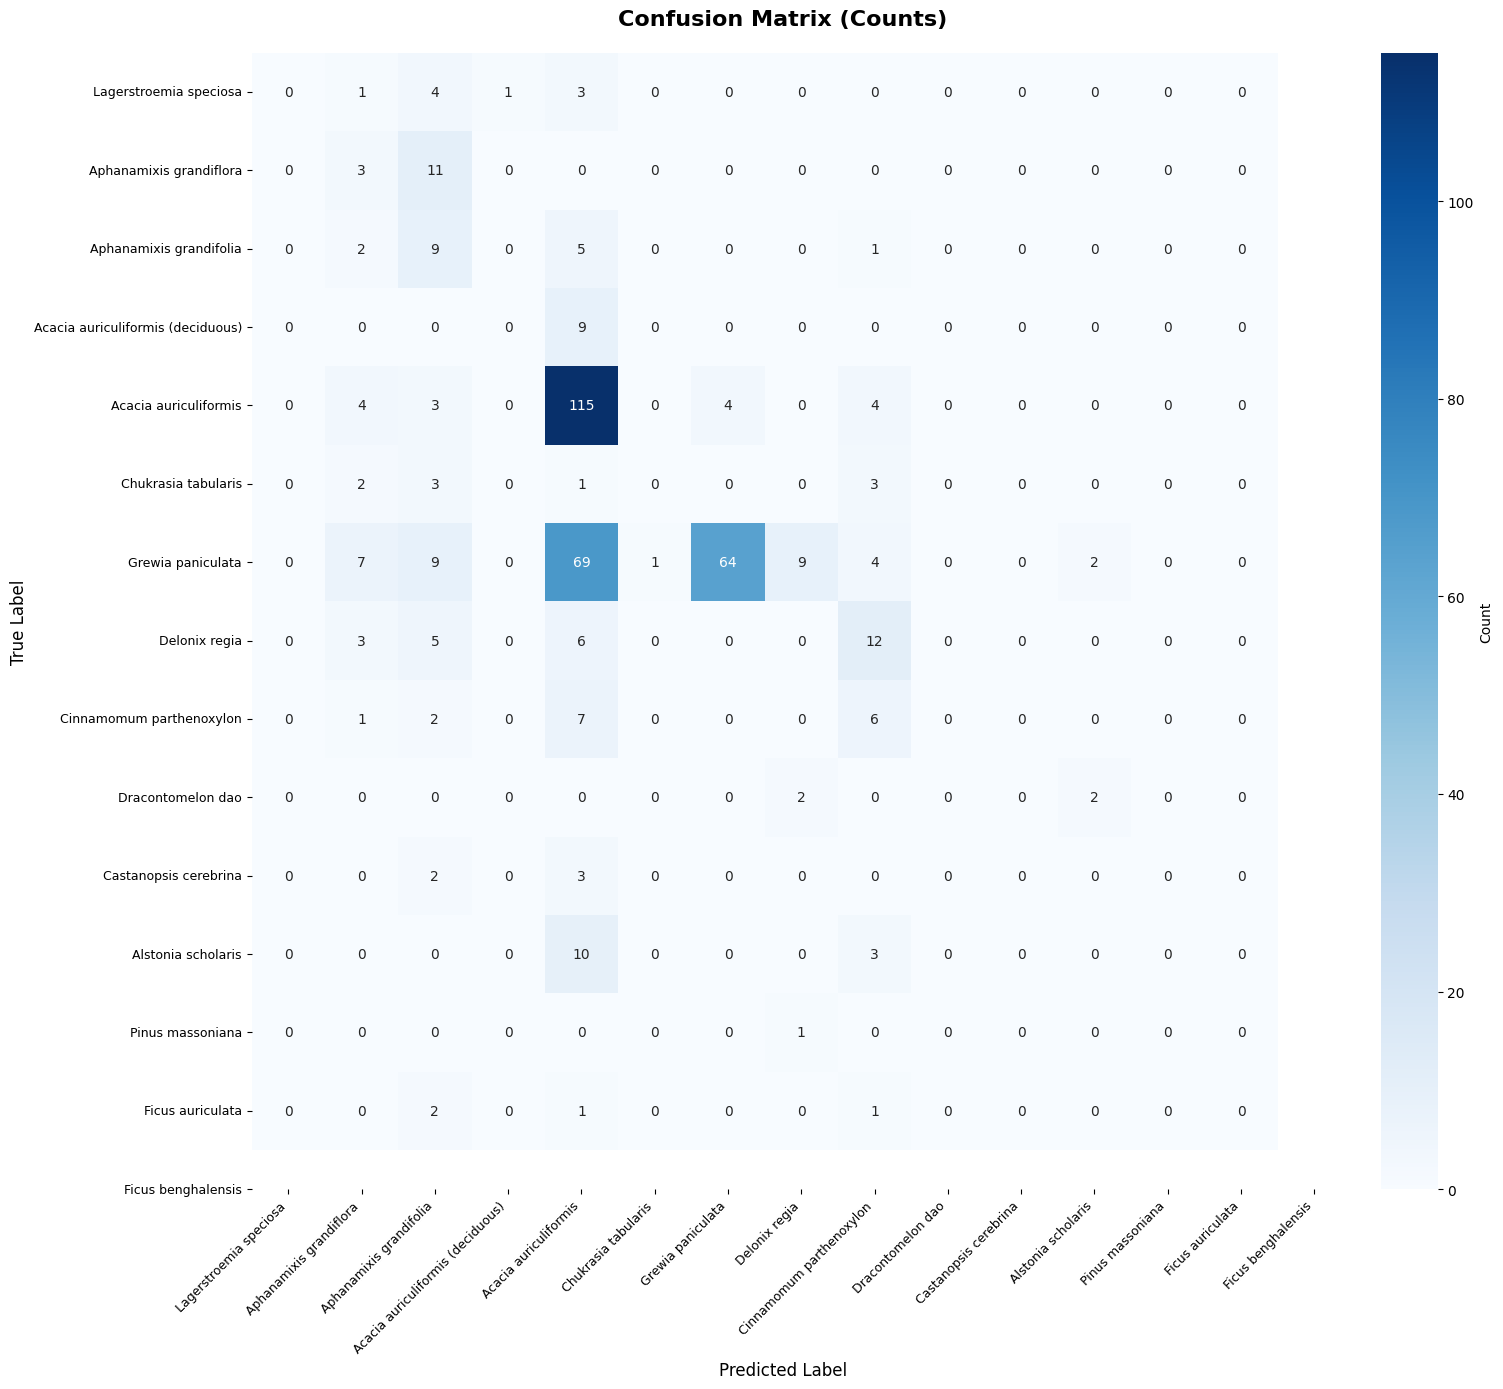


🎉 FINAL TEST RESULTS:
   Accuracy: 46.68%
   Precision: 13.79%
   Recall: 17.08%
   F1-Score: 13.29%


{'test_accuracy': 46.682464454976305,
 'test_precision': 13.787608911041158,
 'test_recall': 17.079940367755494,
 'test_f1_score': 13.291740181663705,
 'per_class_metrics': {'Bằng lăng': {'precision': 0.0,
   'recall': 0.0,
   'f1_score': 0.0,
   'support': 9},
  'Gội': {'precision': 13.043478260869565,
   'recall': 21.428571428571427,
   'f1_score': 16.216216216216218,
   'support': 14},
  'Gội trắng': {'precision': 18.0,
   'recall': 52.94117647058824,
   'f1_score': 26.865671641791046,
   'support': 17},
  'Keo Lá Tràm ( Rụng Lá)': {'precision': 0.0,
   'recall': 0.0,
   'f1_score': 0.0,
   'support': 9},
  'Keo lá tràm': {'precision': 50.21834061135371,
   'recall': 88.46153846153845,
   'f1_score': 64.06685236768801,
   'support': 130},
  'Lát Hoa': {'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'support': 9},
  'Phượng vĩ': {'precision': 94.11764705882352,
   'recall': 38.78787878787879,
   'f1_score': 54.93562231759657,
   'support': 165},
  'Re hương': {'precision': 0.0,
  

In [46]:
TEST_DIR = "/content/100_0865_0040_modified_patches"
# 2. Cell này dùng để Test riêng biệt
print("Running Testing Step...")

# Sử dụng model đã lưu từ lần train trước
model_path = f"Single_best_{DEFAULT_CONFIG['model_name']}.pth"
# model_path = "/content/drive/MyDrive/2026_ICCE/vit_base_patch16_224_domain2/Single_best_vit_base_patch16_224.pth"

# Chạy test
run_testing(model_path)

In [47]:
!mkdir /content/drive/MyDrive/2026_ICCE/vit_base_patch16_224_domain1

In [48]:
!mv /content/Single_best_vit_base_patch16_224.pth /content/drive/MyDrive/2026_ICCE/vit_base_patch16_224_domain1